# A Data-driven Battery Performance Estimator Using Deep Learning Frameworks

A dissertation submitted to The University of Manchester.

## Dataset

**Data set: Saved to directory in "battery_data" file**

This dissertation utilizes the Li-ion Battery Aging Datasets available at NASA's Open Data Portal "https://data.nasa.gov/dataset/Li-ion-Battery-Aging-Datasets/uj5r-zjdb/about_data"

"This data set has been collected from a custom built battery prognostics testbed at the NASA Ames Prognostics Center of Excellence (PCoE). Li-ion batteries were run through 3 different operational profiles (charge, discharge and Electrochemical Impedance Spectroscopy) at different temperatures. Discharges were carried out at different current load levels until the battery voltage fell to preset voltage thresholds. Some of these thresholds were lower than that recommended by the OEM (2.7 V) in order to induce deep discharge aging effects. Repeated charge and discharge cycles result in accelerated aging of the batteries. The experiments were stopped when the batteries reached the end-of-life (EOL) criteria of 30% fade in rated capacity (from 2 Ah to 1.4 Ah)."

**Data Acquisition:**

The testbed comprises:

* Commercially available Li-ion 18650 sized rechargeable batteries,
* Programmable 4-channel DC electronic load,
* Programmable 4-channel DC power supply,
* Voltmeter, ammeter and thermocouple sensor suite,
* Custom EIS equipment,
* Environmental chamber to impose various operational conditions,
* PXI chassis based DAQ and experiment control, and



MATLAB based experiment control, data acquisition and prognostics algorithm evaluation setup (appx. data acquisition rate is 10Hz).


**Data Description**:
A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

Files:
B0005.mat	Data for Battery #5
B0006.mat	Data for Battery #6
B0007.mat	Data for Battery #7
B0018.mat	Data for Battery #18

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)
```

### Import Libraries

Below are all the libraries needed for the data processing and TRAINING.

In [1]:
import datetime                                     # for reading date and time from the dataset
import numpy as np                                  # for mathematical operations and linear algebra, etc..
import pandas as pd                                 # for dataframes
from scipy.io import loadmat                        # used "from" so loadmatcan be used directly, used to read .mat files
from sklearn.preprocessing import MinMaxScaler      # for scaling features
from sklearn.metrics import mean_squared_error      # for training loss
from sklearn import metrics                         # for r-squared statistic
import matplotlib.pyplot as plt                     # for plotting
import matplotlib.cm as cm                          # for the voltage plots
import seaborn as sns                               # for data visualization on top of matplotlib
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

## Data Acquisition
Loading data to workspace using functions from: https://github.com/psanabriaUC/BatteryDatasetImplementation

Transforming datasets from .mat files.

In [3]:
def load_data(battery):
    mat_file = loadmat('battery_data/' + battery +'.mat')
    print('Number of datapoint:', len(mat_file[battery][0, 0]['cycle'][0]))    # access first column ([0]) in 'cycle' which is the first and only content of the cell [0,0] in the battery structure [B00X]
    # Note index 1 in matlab is 0 in python
    # Initialize variables and lists
    discharging_cycle = 1 
    charging_cycle = 1
    discharge_dataset = []
    capacity_data = []
    charge_dataset = [] 

    for i in range(len(mat_file[battery][0,0]['cycle'][0])):
        # Create row dictionary to access the fields 'type', 'ambient_temperature', 'time', 'data'.
        row = mat_file[battery][0,0]['cycle'][0,i]
        # Load discharging profile dataset.
        if row['type'][0] == 'discharge':
            ambient_temp = row['ambient_temperature'][0][0]         # Access first row in first column of ambient temp
            # Time is given as [2008,4,2,13,8,17.921000000000000]
            # datetime requires integer inputs
            # Timedelta is added to the datetime object created in the previous step. 
            # This addition adjusts the time by the specified number of seconds.
            date_time = datetime.datetime(int(row['time'][0][0]),   # year
                                          int(row['time'][0][1]),   # month 
                                          int(row['time'][0][2]),   # day
                                          int(row['time'][0][3]),   # hour
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))   # minutes and seconds
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            capacity_data.append([discharging_cycle, ambient_temp, date_time, capacity])
            for j in range(len(data[0][0]['Voltage_measured'][0])):     # Voltage_measured contains a structure of 1 x 789 for B005, so iterate for j=789 times. 
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                discharge_dataset.append([discharging_cycle, ambient_temp, date_time, capacity,  # Move capacity to the end to match charging data
                                voltage_measured, current_measured, 
                                temperature_measured, current_load,
                                voltage_load, time])
            discharging_cycle = discharging_cycle + 1
        # Now load charging profile dataset.
        elif row['type'][0] == 'charge':
            ambient_temp = row['ambient_temperature'][0][0]         # Access first row in first column of ambient temp
            # Time is given as [2008,4,2,13,8,17.921000000000000]
            # datetime requires integer inputs
            # Timedelta is added to the datetime object created in the previous step. 
            # This addition adjusts the time by the specified number of seconds.
            date_time = datetime.datetime(int(row['time'][0][0]),   # year
                                          int(row['time'][0][1]),   # month 
                                          int(row['time'][0][2]),   # day
                                          int(row['time'][0][3]),   # hour
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))   # minutes and seconds
            data = row['data']
            for j in range(len(data[0][0]['Voltage_measured'][0])):     # Voltage_measured contains a structure of 1 x 789 for B005, so iterate for j=789 times. 
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_charge = data[0][0]['Current_charge'][0][j]
                voltage_charge = data[0][0]['Voltage_charge'][0][j]
                time = data[0][0]['Time'][0][j]
                charge_dataset.append([charging_cycle, ambient_temp, date_time,
                                voltage_measured, current_measured, 
                                temperature_measured, current_charge,
                                voltage_charge, time])
            charging_cycle = charging_cycle + 1
    print(discharge_dataset[0])
    print(charge_dataset[0])
    return [pd.DataFrame(data = discharge_dataset,
                         columns = ['cycle','ambient_temperature','datetime',
                                   'capacity', 'voltage_measured',
                                   'current_measured', 'temperature_measured',
                                   'current_load','voltage_load','time']),
            pd.DataFrame(data = capacity_data,
                         columns = ['cycle','ambient_temperature','datetime',
                                    'capacity']),
            pd.DataFrame(data=charge_dataset,
                         columns = ['cycle','ambient_temperature','datetime',
                                   'voltage_measured','current_measured',
                                   'temperature_measured', 'current_charge',
                                   'voltage_charge','time']), discharging_cycle, charging_cycle]
# To call the load_data function:
battery = 'B0005'                            # 'B0005' or 'B0006' or 'B0007' or 'B0018'
discharge_dataset_5, capacity_5, charge_dataset_5, discharging_cycles_5, charging_cycles_5 = load_data('B0005')
discharge_dataset_6, capacity_6, charge_dataset_6, discharging_cycles_6, charging_cycles_6 = load_data('B0006')
discharge_dataset_7, capacity_7, charge_dataset_7, discharging_cycles_7, charging_cycles_7 = load_data('B0007')
discharge_dataset_18, capacity_18, charge_dataset_18, discharging_cycles_18, charging_cycles_18 = load_data('B0018')

pd.set_option('display.max_columns',10)     # Just show 10 points??
print(discharge_dataset_5.head())
discharge_dataset_5.describe()
print(charge_dataset_5.head())
charge_dataset_5.describe()

                

Number of datapoint: 616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
[1, 24, datetime.datetime(2008, 4, 2, 13, 8, 17), 3.873017221300996, -0.001200660698297908, 24.65535783391511, 0.0, 0.003, 0.0]
Number of datapoint: 616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
[1, 24, datetime.datetime(2008, 4, 2, 13, 8, 17), 3.864623580255829, 8.199926367719631e-05, 24.682213821908466, -0.001, -0.007, 0.0]
Number of datapoint: 616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]
[1, 24, datetime.datetime(2008, 4, 2, 13, 8, 17), 3.866123109975637, -0.0038300299369588755, 24.434243987750175, -0.0006, 0.002, 0.0]
Number of datapoint: 319
[1, 24, datetime.datetime(2008, 7, 7, 15, 15, 28), 

cycle  ambient_temperature                       datetime  \
count  541173.000000             541173.0                         541173   
mean       96.606471                 24.0  2008-05-09 06:46:20.295431936   
min         1.000000                 24.0            2008-04-02 13:08:17   
25%        62.000000                 24.0            2008-05-01 19:38:17   
50%        97.000000                 24.0            2008-05-10 17:36:13   
75%       133.000000                 24.0            2008-05-18 23:53:33   
max       170.000000                 24.0            2008-05-28 11:09:42   
std        42.702483                  0.0                            NaN   

       voltage_measured  current_measured  temperature_measured  \
count     541173.000000     541173.000000         541173.000000   
mean           4.158644          0.571543             25.770628   
min            0.003365         -4.479660             23.246728   
25%            4.195473          0.058024             24.438659   
50%            4.205310          0.227544             25.255235   
75%            4.205978          1.506508             26.819807   
max            8.393141          1.531301             31.187718   
std            0.098078          0.620454              1.643729   

       current_charge  voltage_charge           time  
count   541173.000000   541173.000000  541173.000000  
mean         0.566810        4.184427    5062.836059  
min         -4.468000        0.003000       0.000000  
25%          0.057000        4.250000    2271.610000  
50%          0.225000        4.332000    4982.078000  
75%          1.498000        4.688000    7763.219000  
max          1.500000        5.002000   10807.328000  
std          0.616015        1.112792    3114.798871

I need to create a copy of the datasets but without the datetime, ambient temp, voltage load, and current load from discharging profiles.

Discharging voltages did not need clipping, unlike charging voltages.

Normalize 

Combine processed data and save.

## Plotting Datasets

The following plots illustrate the aging process of the battery as the charge and discharge cycles progress. The horizontal line represents the EOL capacity which is 70% of the maximum capacity. 

### Capacity Plot

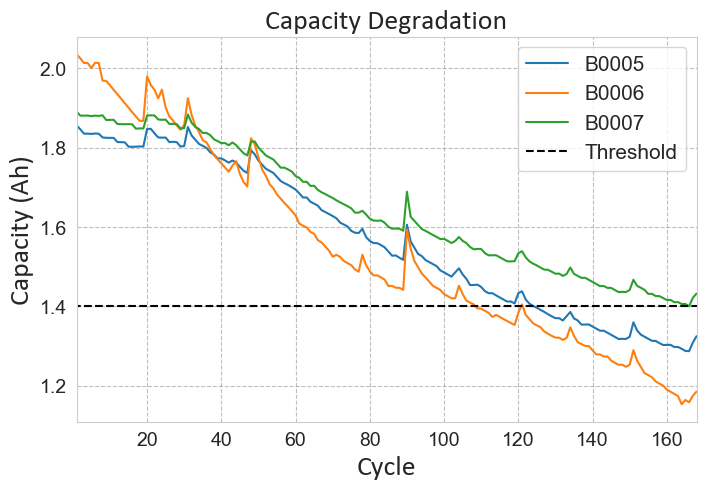

In [4]:
capacity_df_5 = capacity_5.loc[(capacity_5['cycle'] >= 1), ['cycle', 'capacity']]
capacity_df_6 = capacity_6.loc[(capacity_6['cycle'] >= 1), ['cycle', 'capacity']]
capacity_df_7 = capacity_7.loc[(capacity_7['cycle'] >= 1), ['cycle', 'capacity']]
capacity_df_18 = capacity_18.loc[(capacity_18['cycle'] >= 1), ['cycle', 'capacity']]

# Plotting settings
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# Plot each dataframe
plt.plot(capacity_df_5['cycle'], capacity_df_5['capacity'], label='B0005')
plt.plot(capacity_df_6['cycle'], capacity_df_6['capacity'], label='B0006')
plt.plot(capacity_df_7['cycle'], capacity_df_7['capacity'], label='B0007')
# plt.plot(capacity_df_18['cycle'], capacity_df_18['capacity'], label='B0018')

# Add labels, title, legend
plt.xlabel('Cycle', fontname='Calibri', fontsize=20)
plt.ylabel('Capacity (Ah)', fontname='Calibri', fontsize=20)
plt.title(f'Capacity Degradation', fontname='Calibri', fontsize=20)

# Draw EOL Capacity at 1.4 Ah
plt.plot([0., len(capacity_5)], [1.4, 1.4], color='black',linestyle='--', label='Threshold')
plt.legend(fontsize=15)  # Show legend to differentiate the lines

# Set axis limits
plt.xlim(capacity_df_5['cycle'].min(), capacity_df_5['cycle'].max())
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=14)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

plt.savefig('capacity_degradation.pdf', format='pdf')

# Show plot
plt.show()



### Voltage Plot - Discharging Cycles 

Plots of the measured battery voltages during the discharging cycles. A seperate plot is provided for each battery.

#### Battery B0005

Number of discharging cycles:  169


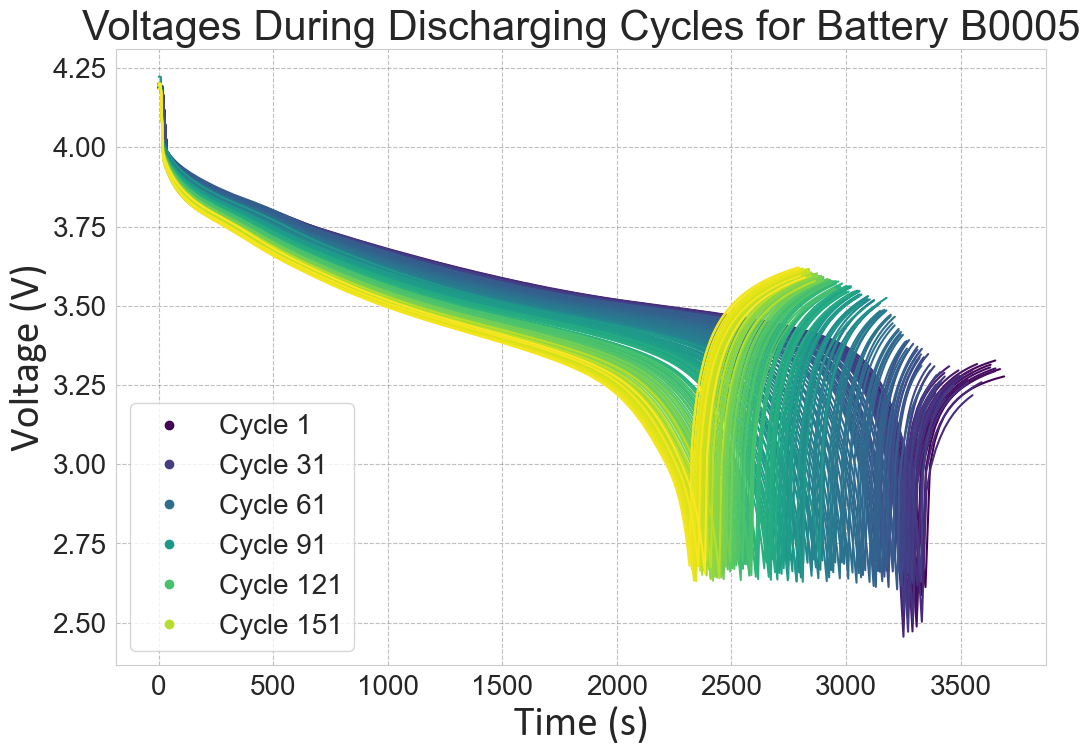

In [5]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_5))

for cycle in range(1, discharging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_5 = discharge_dataset_5.loc[discharge_dataset_5['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_5['time'], cycle_data_5['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_5, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontsize=30, fontname='Calibri')
plt.ylabel('Voltage (V)' , fontsize=30, fontname='Calibri')
plt.title('Voltages During Discharging Cycles for Battery B0005', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
# Save the plot as pdf
# Specify the directory name
folder_name = '8. Discharge Plots'

# Create the directory if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

plt.savefig(os.path.join(folder_name, 'b0005_voltage.pdf'), format='pdf')

# Show the plot
plt.show()


B0005 discharging:       

                CC mode 2 A         
                Voltage 2.7 V       

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

#### Battery B0006

Number of discharging cycles:  169


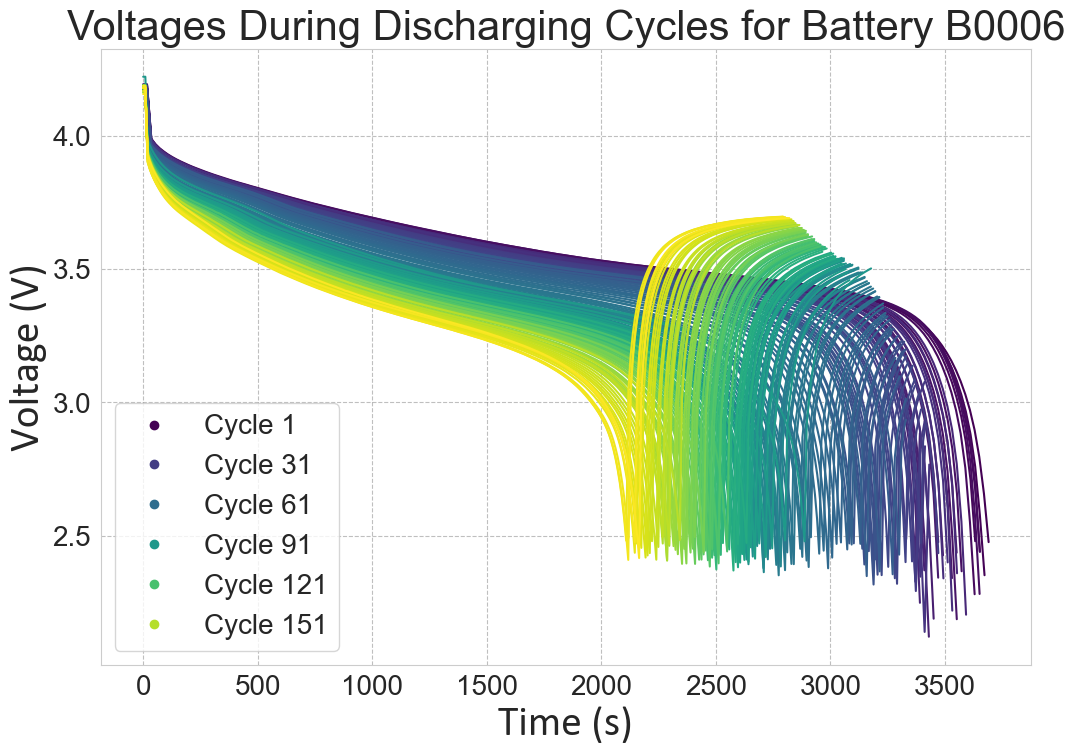

In [6]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_6))

for cycle in range(1, discharging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_6 = discharge_dataset_6.loc[discharge_dataset_6['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_6['time'], cycle_data_6['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_6, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Discharging Cycles for Battery B0006', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0006_voltage.pdf'), format='pdf')

# Show the plot
plt.show()


B0006 discharging:       

                CC mode 2 A         
                Voltage 2.5 V       

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

#### B0007

Number of discharging cycles:  169


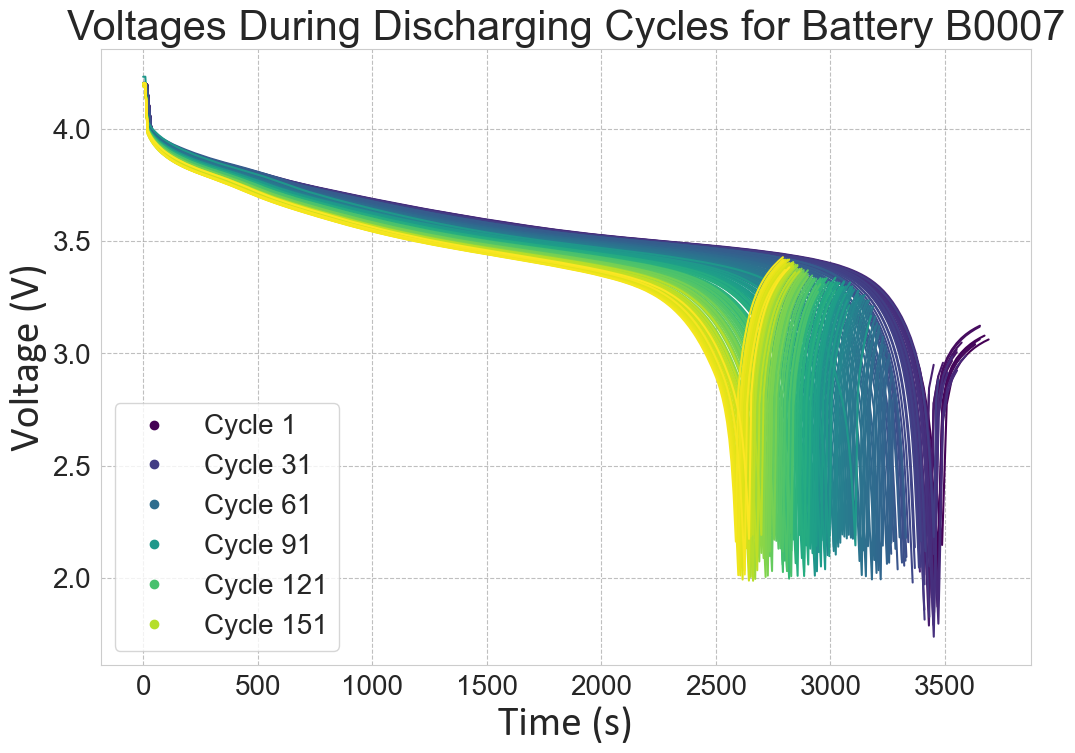

In [7]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_7))      # or cm.cividis cm.magma or cm.coolwarm

for cycle in range(1, discharging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_7 = discharge_dataset_7.loc[discharge_dataset_7['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_7['time'], cycle_data_7['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_7, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Discharging Cycles for Battery B0007', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0007_voltage.pdf'), format='pdf')

# Show the plot
plt.show()


B0007 discharging:       

                CC mode 2 A         
                Voltage 2.2 V       

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

#### B0018

Number of discharging cycles:  133


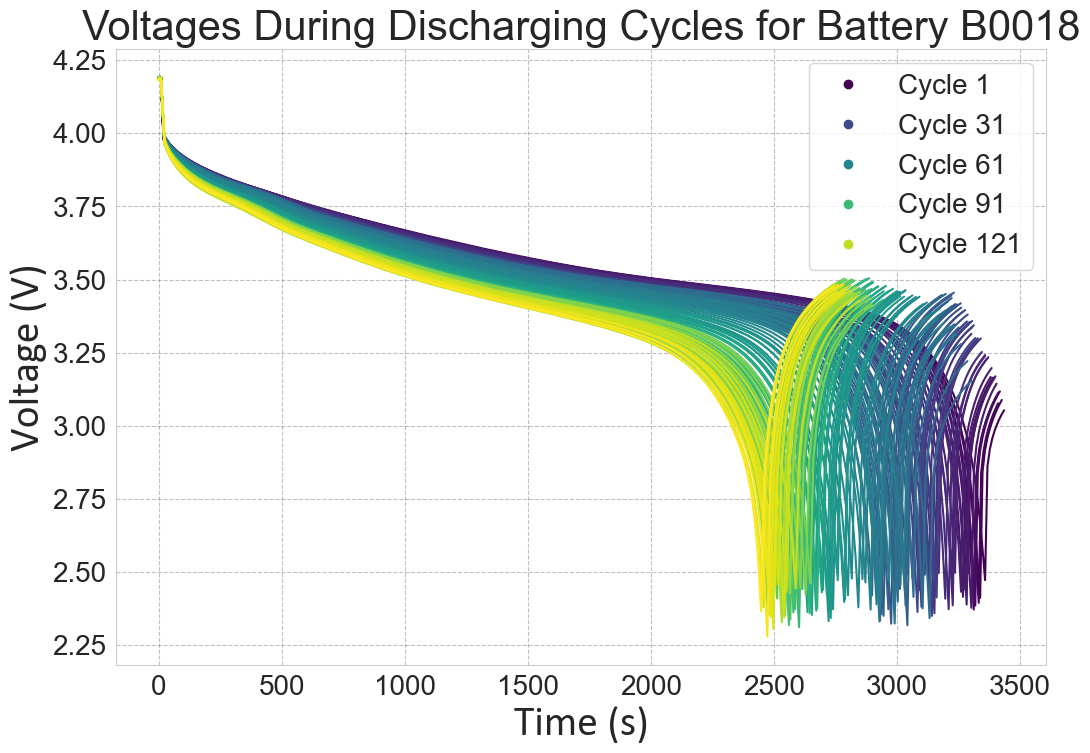

In [8]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_18))      # or cm.cividis cm.magma or cm.coolwarm

for cycle in range(1, discharging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_18 = discharge_dataset_18.loc[discharge_dataset_18['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_18['time'], cycle_data_18['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_18, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Discharging Cycles for Battery B0018', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()


B0018 discharging:       

                CC mode 2 A         
                Voltage 2.5 V       

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

### Ignore

A comparison between two cycles.

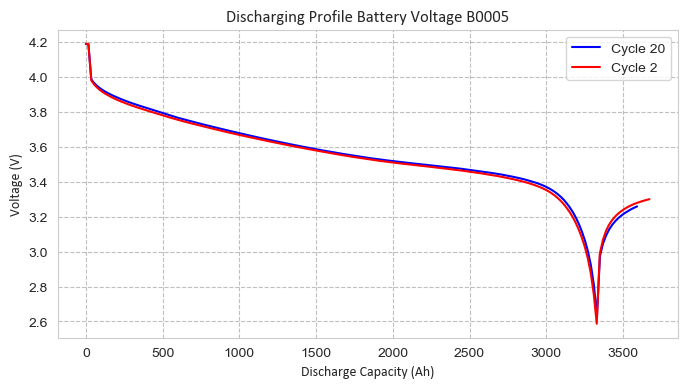

In [9]:
## Discharging Voltage

# Extract data for cycle 20
disch_voltage_df_20 = discharge_dataset_5.loc[(discharge_dataset_5['cycle'] == 20), ['time', 'voltage_measured']]

# Extract data for cycle 2
disch_voltage_df_2 = discharge_dataset_5.loc[(discharge_dataset_5['cycle'] == 2), ['time', 'voltage_measured']]

# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(8, 4))

# Plot cycle 20
plt.plot(disch_voltage_df_20['time'], disch_voltage_df_20['voltage_measured'], label='Cycle 20', color='blue')

# Plot cycle 2
plt.plot(disch_voltage_df_2['time'], disch_voltage_df_2['voltage_measured'], label='Cycle 2', color='red')

# Set labels and title
plt.xlabel('Discharge Capacity (Ah)', fontname='Calibri')  # or Verdana or Tahoma or Trebuchet MS
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Discharging Profile Battery Voltage ' + battery, fontname='Calibri')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Add a legend to distinguish the curves
plt.legend()

# Optionally, if you want to mark a specific end of life (EOL) capacity at 1.4 Ah
#plt.plot([0, max(max(disch_voltage_df_20['time']), max(disch_voltage_df_2['time']))], [1.4, 1.4], color='black', linestyle='--')

# Show the plot
plt.show()



### Current Plot - Discharging Cycles

Plots of the measured currents during the discharging cycles. A seperate plot is provided for each battery.

#### Battery B0005

Number of discharging cycles:  169


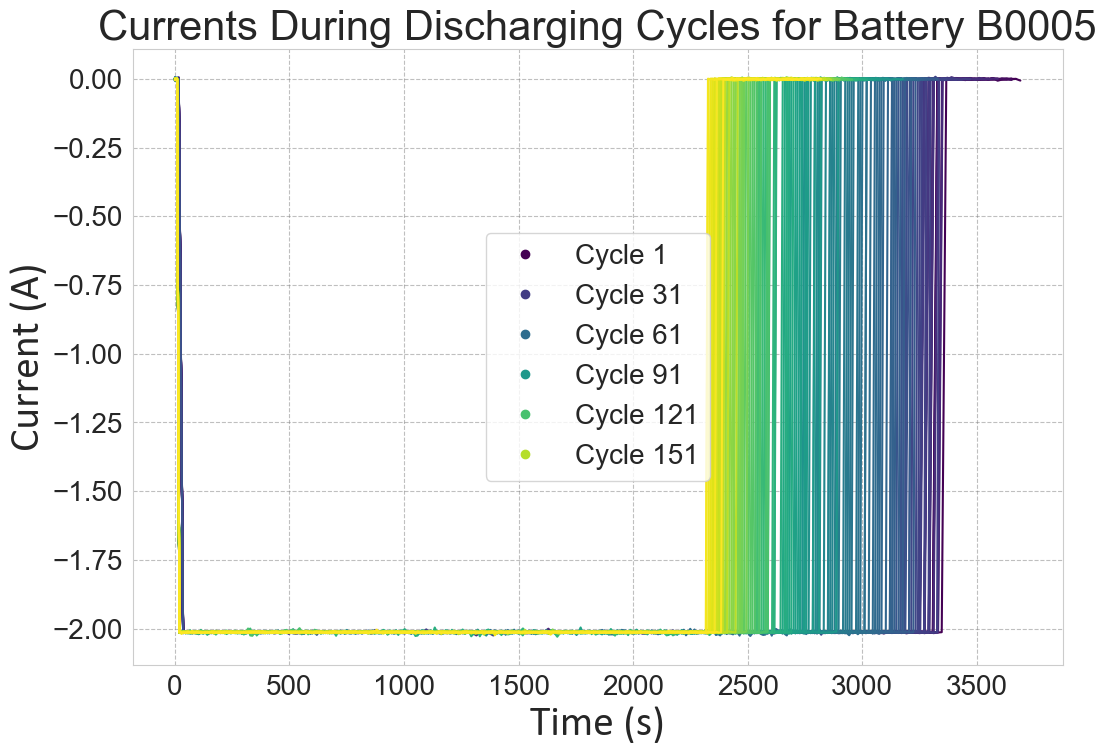

In [10]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of discharging cycles: ',discharging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_5))

for cycle in range(1, discharging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_5 = discharge_dataset_5.loc[discharge_dataset_5['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_5['time'], cycle_data_5['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_5, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Discharging Cycles for Battery B0005', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0005_current.pdf'), format='pdf')

# Show the plot
plt.show()

B0005 discharging:       

                CC mode 2 A         
                Voltage 2.7 V       

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

#### Battery B0006

Number of discharging cycles:  169


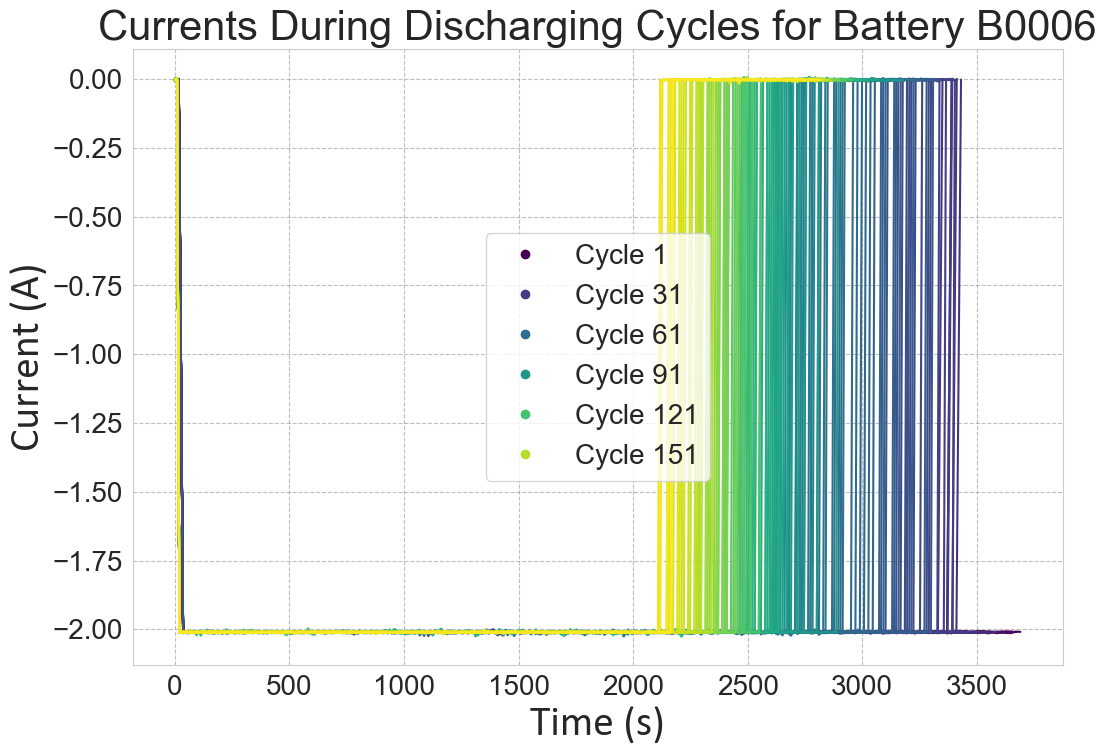

In [11]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of discharging cycles: ',discharging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_6))

for cycle in range(1, discharging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_6 = discharge_dataset_6.loc[discharge_dataset_6['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_6['time'], cycle_data_6['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_6, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Discharging Cycles for Battery B0006', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0006_current.pdf'), format='pdf')

# Show the plot
plt.show()

B0006 discharging:       

                CC mode 2 A             
                Voltage 2.5 V           

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

#### Battery B0007

Number of discharging cycles:  169


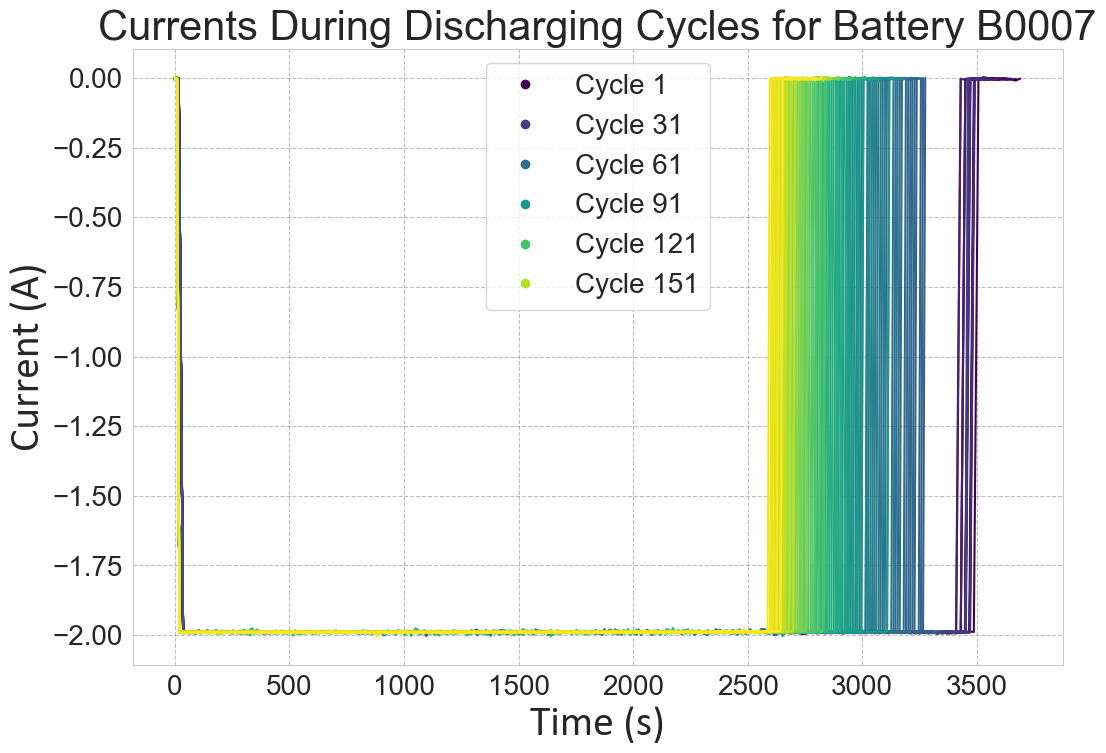

In [12]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of discharging cycles: ',discharging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_7))

for cycle in range(1, discharging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_7 = discharge_dataset_7.loc[discharge_dataset_7['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_7['time'], cycle_data_7['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_7, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Discharging Cycles for Battery B0007', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0007_current.pdf'), format='pdf')

# Show the plot
plt.show()

B0007 discharging:       

                CC level 2 A                
                Voltage 2.2 V               

All batteries were discharged to a different voltage level. However, B0006 and B0018 are equivalent.

#### Battery B0018

Number of discharging cycles:  133


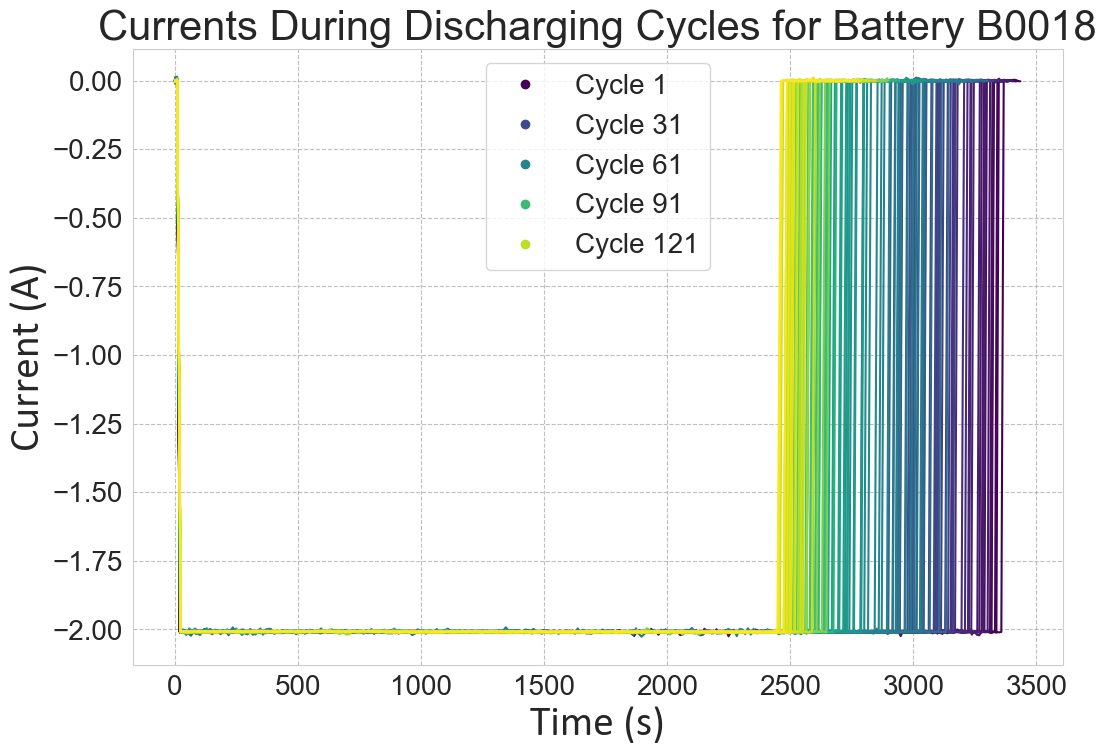

In [13]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of discharging cycles: ',discharging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_18))

for cycle in range(1, discharging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_18 = discharge_dataset_18.loc[discharge_dataset_18['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_18['time'], cycle_data_18['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_18, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Discharging Cycles for Battery B0018', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

B0018 discharging:       

                CC mode 2 A             
                Voltage 2.5 V           

All batteries were discharged to a different voltage level. However B0006 and B0018 are equivalent.

### Temperature Plots During Discharging

#### Battery B0005

Number of discharging cycles:  169


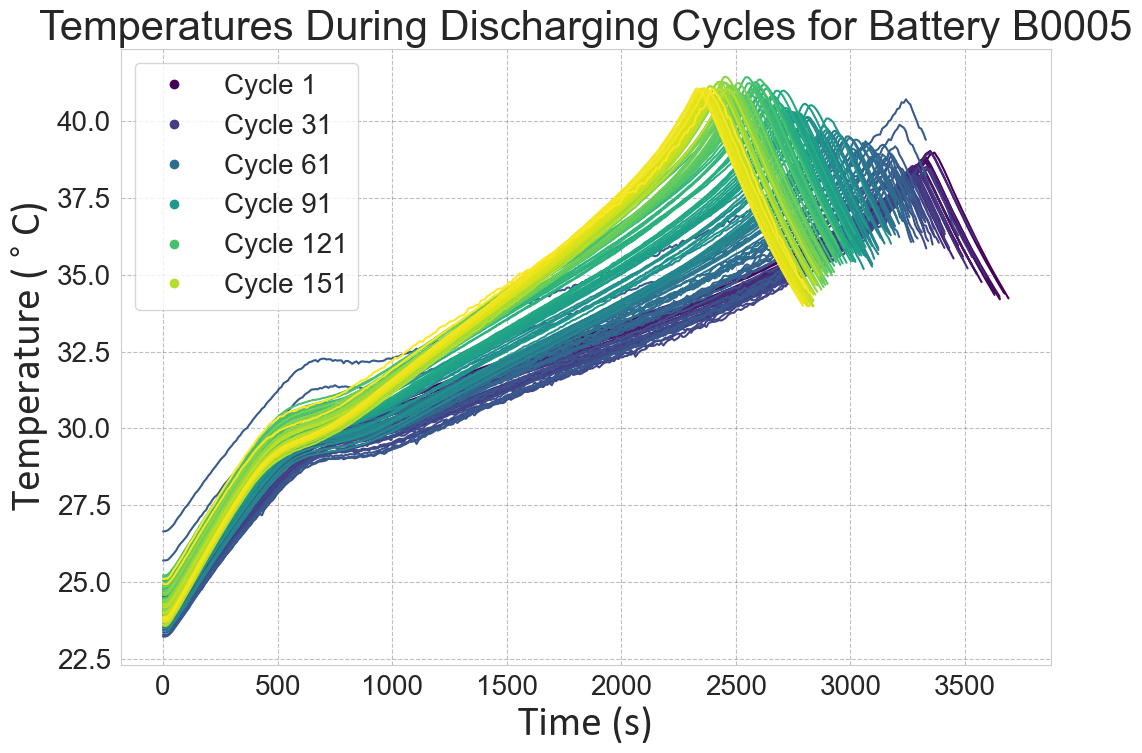

In [52]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_5))

for cycle in range(1, discharging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_5 = discharge_dataset_5.loc[discharge_dataset_5['cycle'] == cycle, ['time', 'temperature_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_5['time'], cycle_data_5['temperature_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_5, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontsize=30, fontname='Calibri')
plt.ylabel('Temperature ($^\circ$C)' , fontsize=30, fontname='Calibri')
plt.title('Temperatures During Discharging Cycles for Battery B0005', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
# Save the plot as pdf
# Specify the directory name
folder_name = '8. Discharge Plots'

# Create the directory if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

plt.savefig(os.path.join(folder_name, 'b0005_temp.pdf'), format='pdf')

# Show the plot
plt.show()


#### Battery B0006

Number of discharging cycles:  169


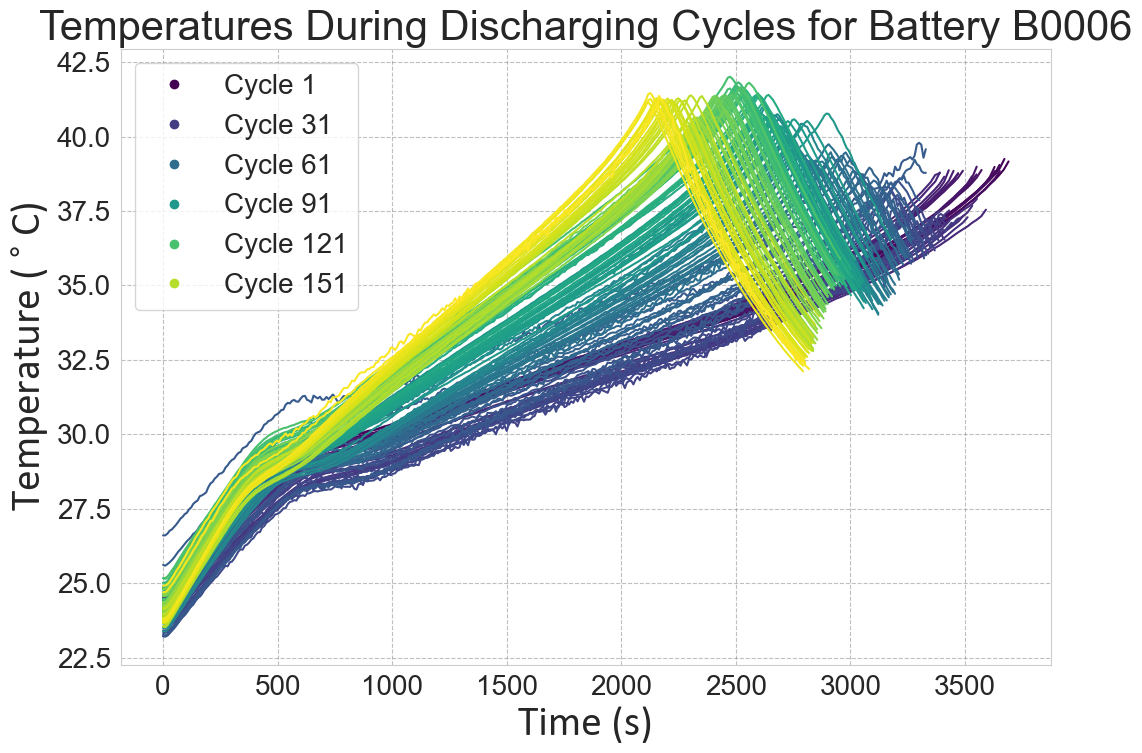

In [53]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_6))

for cycle in range(1, discharging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_6 = discharge_dataset_6.loc[discharge_dataset_6['cycle'] == cycle, ['time', 'temperature_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_6['time'], cycle_data_6['temperature_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_6, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontname='Calibri', fontsize=30)
plt.title('Temperatures During Discharging Cycles for Battery B0006', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0006_temp.pdf'), format='pdf')

# Show the plot
plt.show()


#### Battery B0007

Number of discharging cycles:  169


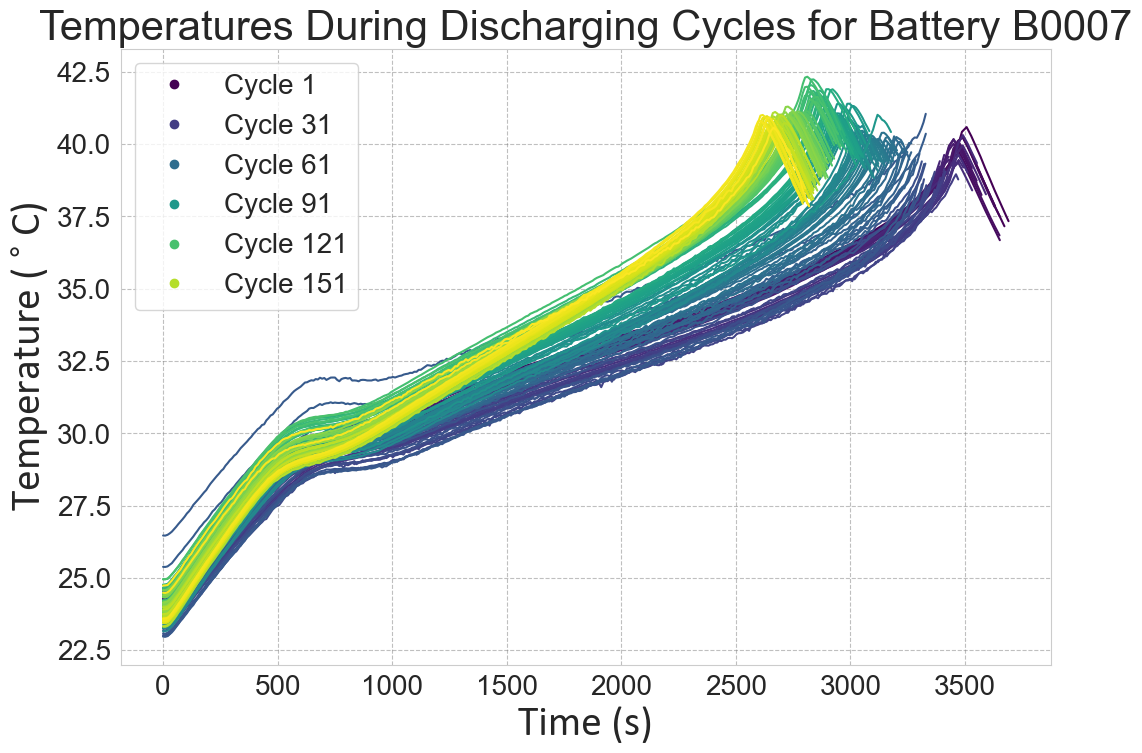

In [54]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Set number of cycles to plot
print('Number of discharging cycles: ',discharging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, discharging_cycles_7))      # or cm.cividis cm.magma or cm.coolwarm

for cycle in range(1, discharging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_7 = discharge_dataset_7.loc[discharge_dataset_7['cycle'] == cycle, ['time', 'temperature_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_7['time'], cycle_data_7['temperature_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/discharging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, discharging_cycles_7, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontname='Calibri', fontsize=30)
plt.title('Temperatures During Discharging Cycles for Battery B0007', fontsize=30)

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_name, 'b0007_temp.pdf'), format='pdf')

# Show the plot
plt.show()


### Charging Profile Voltage Plots

Plots of the measured voltages during charging cycles, for each battery.

#### Battery B0005

The voltage plots exhibit some overshoot that exceeds 4.2 V, which will be treated as outliers. These need to be further processed. 

To remove overshoot, uncomment line 18. It will be smoothed out later using Moving Average.

Number of charging cycles:  171


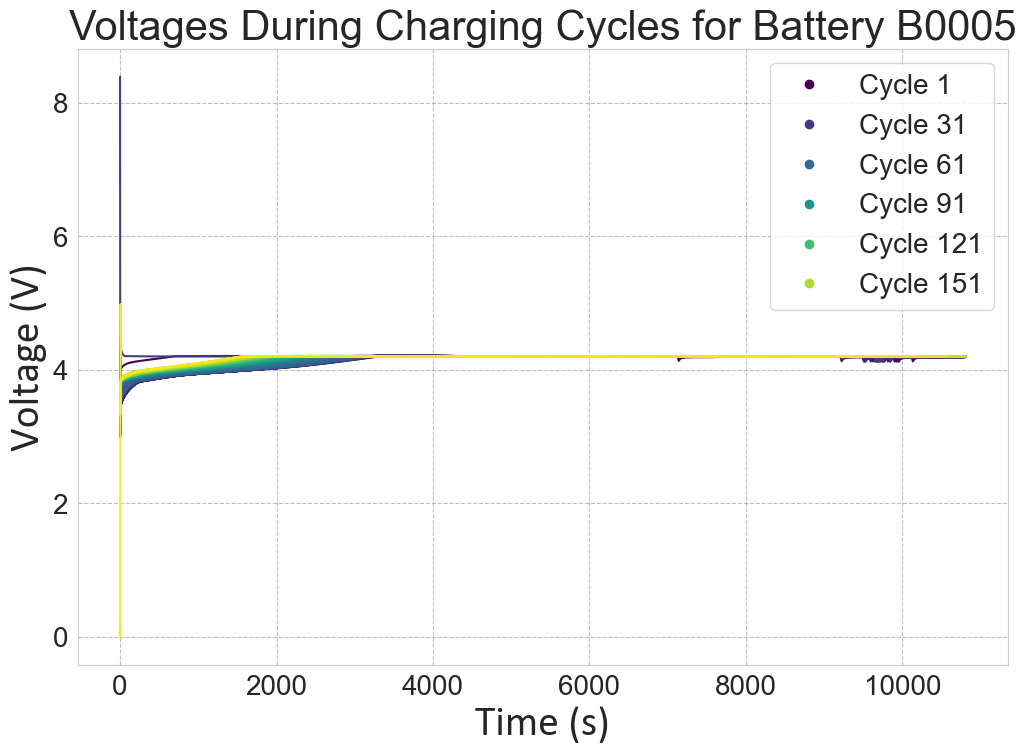

In [14]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_5))

for cycle in range(1, charging_cycles_5 + 1):
    
    # Extract data for each cycle
    cycle_data_5 = charge_dataset_5.loc[charge_dataset_5['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # To remove Overshoot, clip at 4.2 V
    #cycle_data['voltage_measured'] = np.clip(cycle_data['voltage_measured'], a_min=None, a_max=4.2)

    # Plot each cycle with a different color
    plt.plot(cycle_data_5['time'], cycle_data_5['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_5, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Charging Cycles for Battery B0005', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
folder_n= '7. Charge Plots'

# Create the directory if it doesn't exist
if not os.path.exists(folder_n):
    os.makedirs(folder_n)

plt.savefig(os.path.join(folder_n, 'b0005_voltage_ch.pdf'), format='pdf')

# Show the plot
plt.show()


B0005 charging:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

#### Battery B0006

To remove overshoot, uncomment line 17.

Number of charging cycles:  171


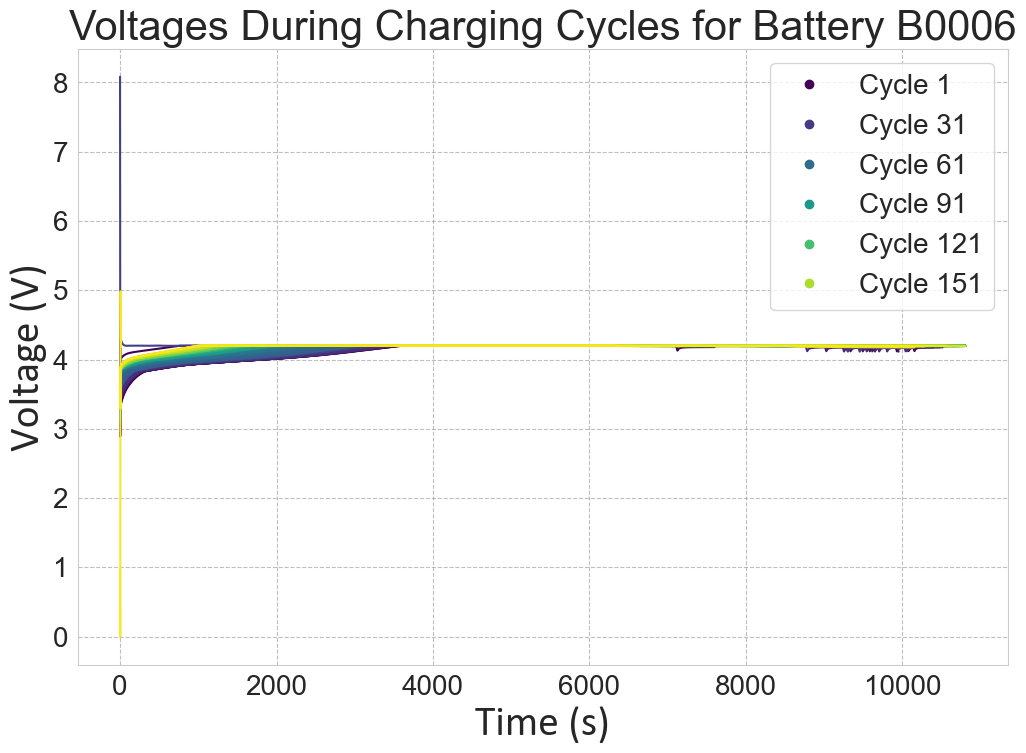

In [15]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_6))

for cycle in range(1, charging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_6 = charge_dataset_6.loc[charge_dataset_6['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # To remove Overshoot, clip at 4.2 V
    #cycle_data['voltage_measured'] = np.clip(cycle_data['voltage_measured'], a_min=None, a_max=4.2)

    # Plot each cycle with a different color
    plt.plot(cycle_data_6['time'], cycle_data_6['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_6, 30)], fontsize=20)
# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Charging Cycles for Battery B0006', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0006_voltage_ch.pdf'), format='pdf')

# Show the plot
plt.show()


B0006 charging:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

#### Battery B0007

To remove overshoot, uncomment line 17.

Number of charging cycles:  171


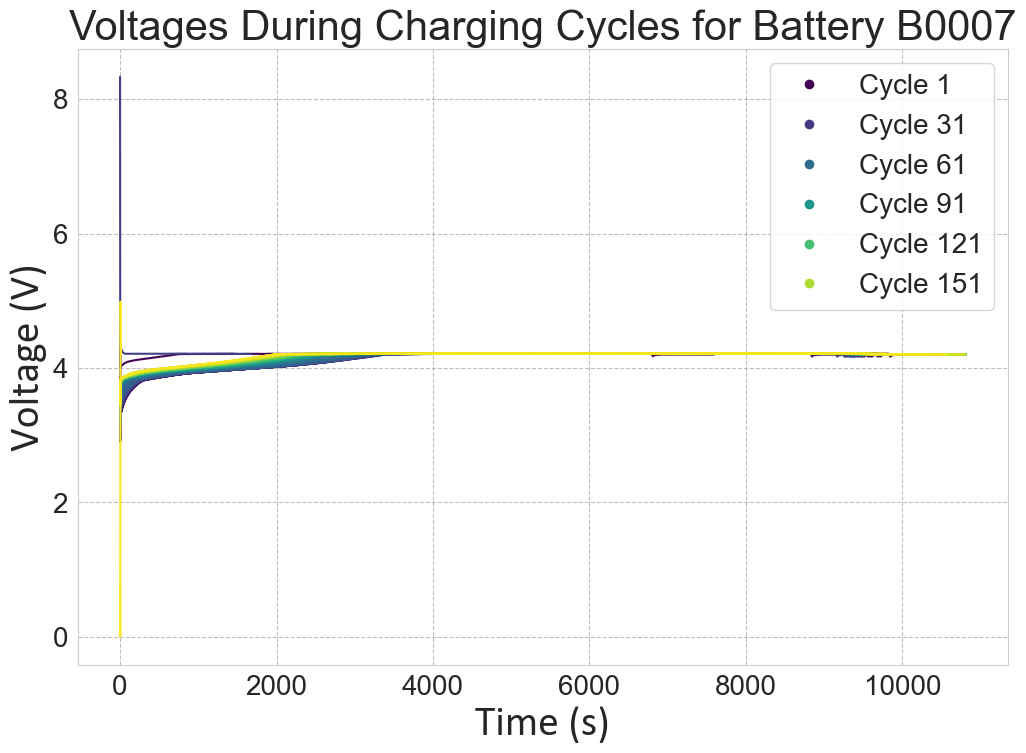

In [16]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_7 = charge_dataset_7.loc[charge_dataset_7['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # To remove Overshoot, clip at 4.2 V
    #cycle_data['voltage_measured'] = np.clip(cycle_data['voltage_measured'], a_min=None, a_max=4.2)

    # Plot each cycle with a different color
    plt.plot(cycle_data_7['time'], cycle_data_7['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_7, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Charging Cycles for Battery B0007', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0007_voltage_ch.pdf'), format='pdf')

# Show the plot
plt.show()


B0007 charging:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

#### Battery B0018

To remove overshoot, uncomment line 17.

Number of charging cycles:  135


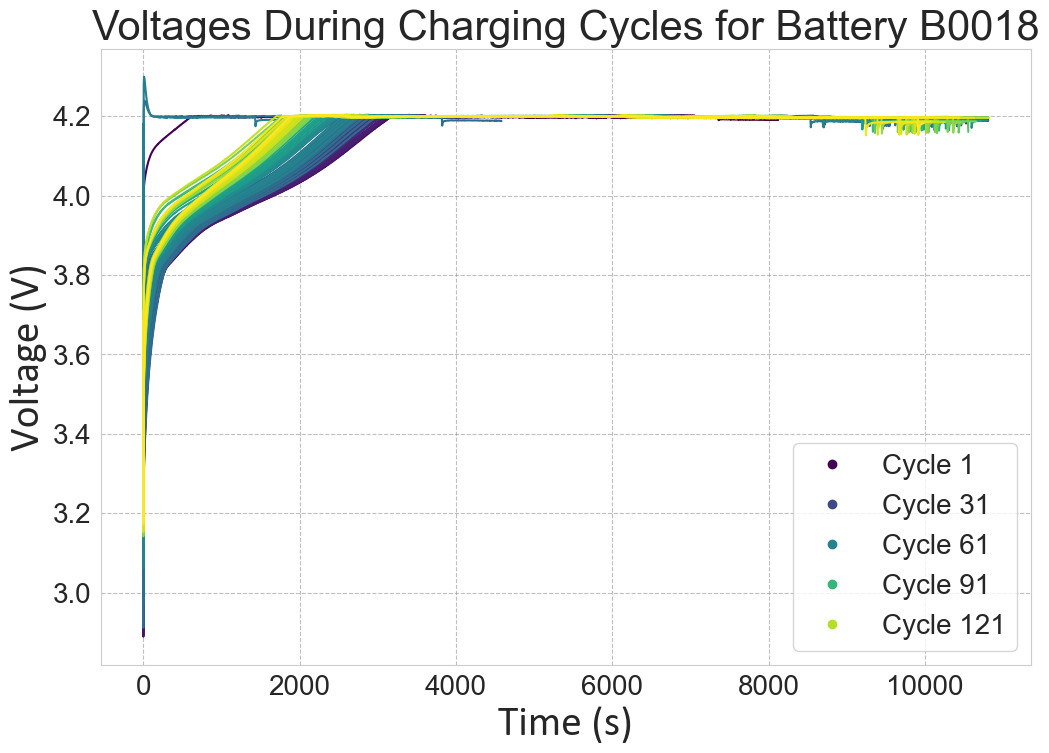

In [17]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_18))

for cycle in range(1, charging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_18 = charge_dataset_18.loc[charge_dataset_18['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # To remove Overshoot, clip at 4.2 V
    #cycle_data['voltage_measured'] = np.clip(cycle_data['voltage_measured'], a_min=None, a_max=4.2)

    # Plot each cycle with a different color
    plt.plot(cycle_data_18['time'], cycle_data_18['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_18, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Voltage (V)', fontname='Calibri', fontsize=30)
plt.title('Voltages During Charging Cycles for Battery B0018', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()


B0018 charging:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

### Charging Profile Current Plot

#### Battery B0005

Number of charging cycles:  171


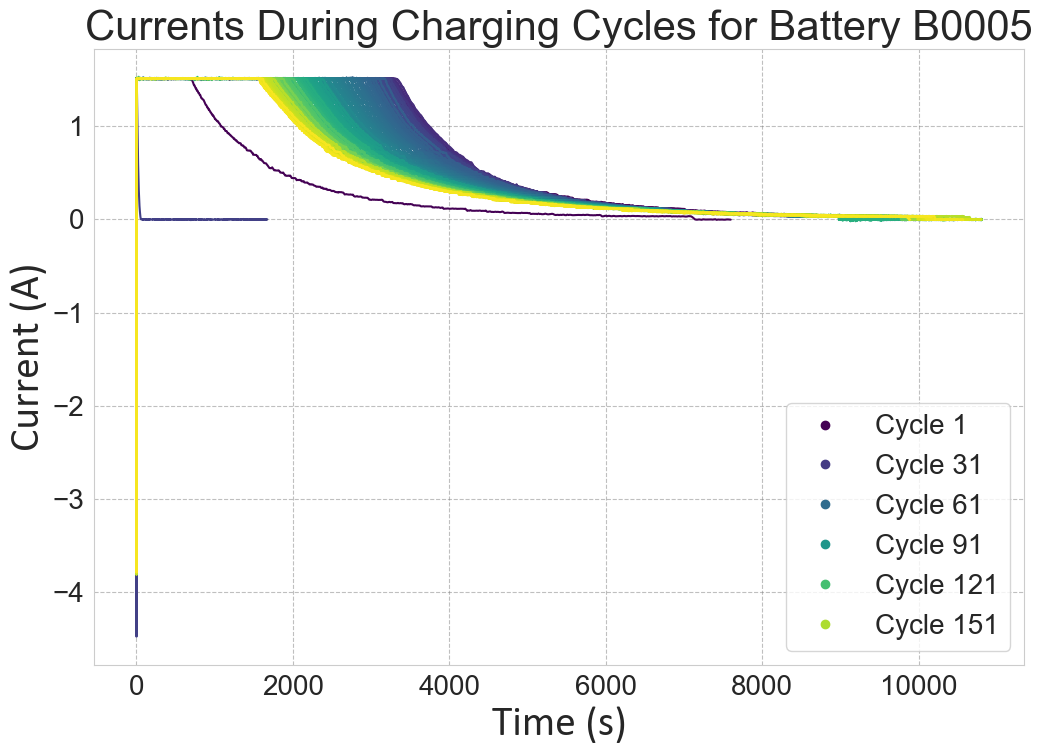

In [18]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_5))

for cycle in range(1, charging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_5 = charge_dataset_5.loc[charge_dataset_5['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_5['time'], cycle_data_5['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_5, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Charging Cycles for Battery B0005', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0005_current_ch.pdf'), format='pdf')

# Show the plot
plt.show()

For B0005:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

#### Battery B0006

Number of charging cycles:  171


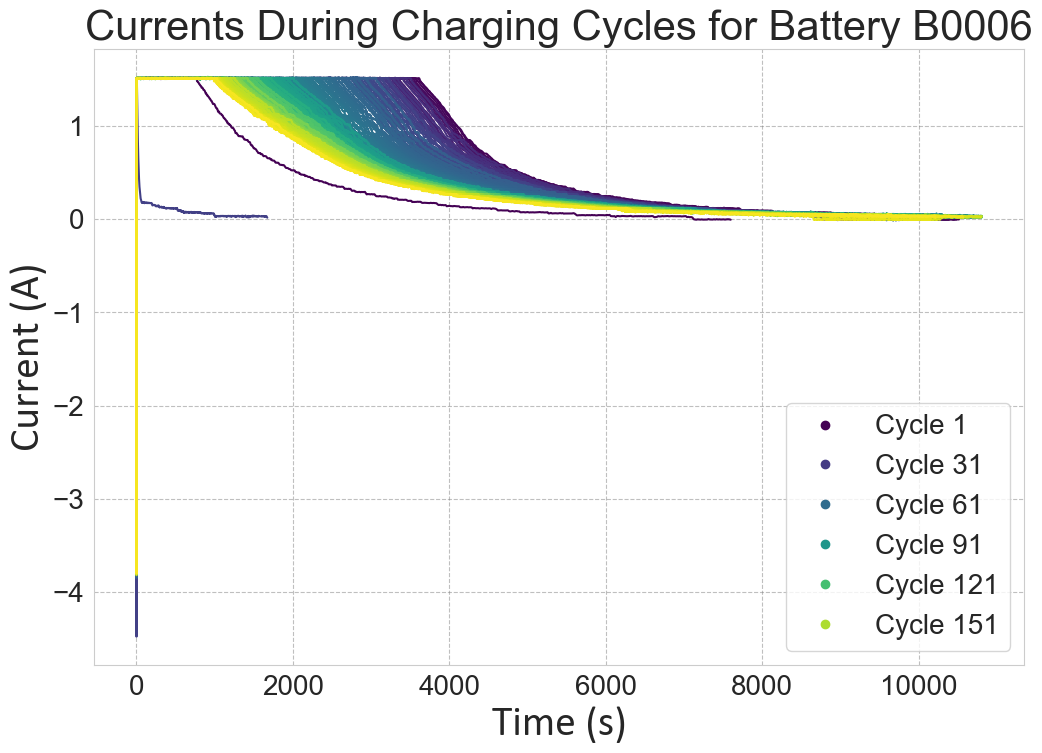

In [19]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_6))

for cycle in range(1, charging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_6 = charge_dataset_6.loc[charge_dataset_6['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_6['time'], cycle_data_6['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_6, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Charging Cycles for Battery B0006', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0006_current_ch.pdf'), format='pdf')

# Show the plot
plt.show()

For B0006:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

#### Battery B0007

Number of charging cycles:  171


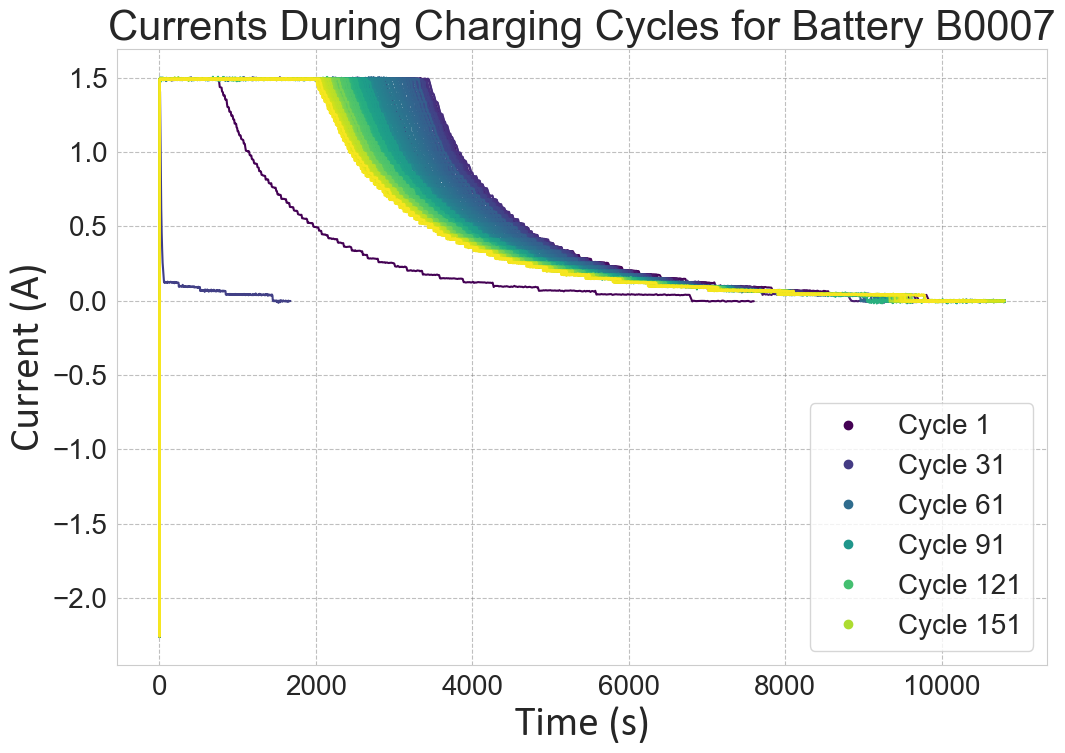

In [20]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_7 = charge_dataset_7.loc[charge_dataset_7['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_7['time'], cycle_data_7['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_7, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Charging Cycles for Battery B0007', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0007_current_ch.pdf'), format='pdf')

# Show the plot
plt.show()

For B0007:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

#### Battery B0018

Number of charging cycles:  135


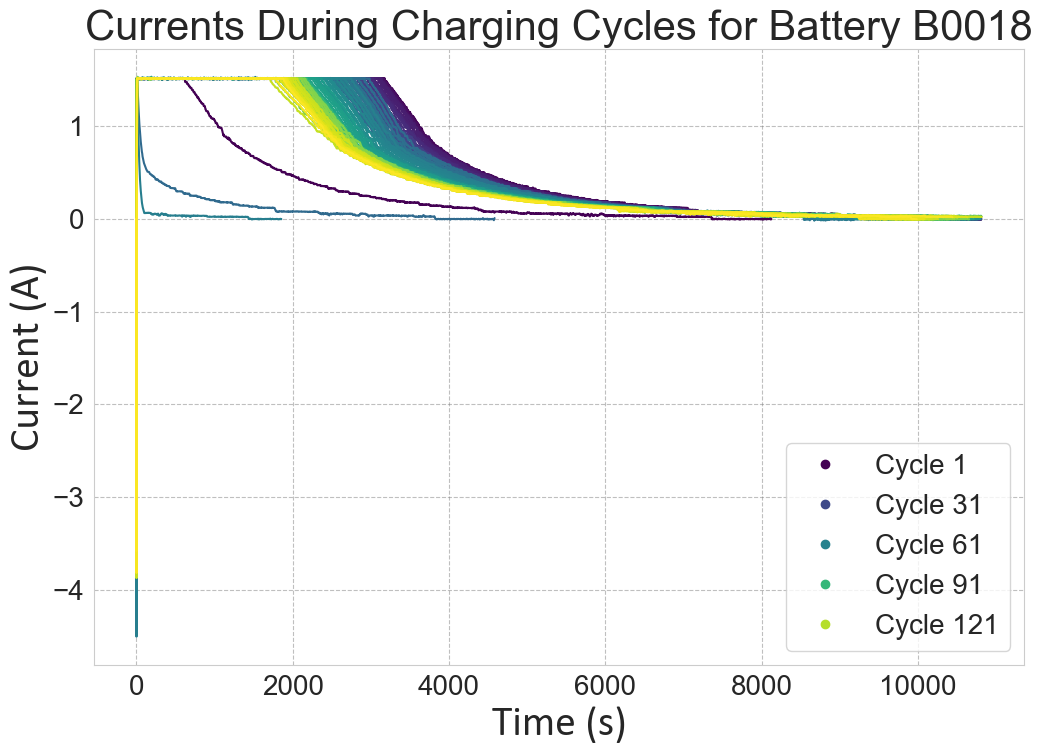

In [21]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_18))

for cycle in range(1, charging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_18 = charge_dataset_18.loc[charge_dataset_18['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_18['time'], cycle_data_18['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_18, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Current (A)', fontname='Calibri', fontsize=30)
plt.title('Currents During Charging Cycles for Battery B0018', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

For B0018:       

                CC mode 1.5 A                           
                CV mode 4.2 V   until current is 20 mA  

All batteries were charged similarly.

### Temperature Plots During Charging

#### Battery B0005

Number of charging cycles:  171


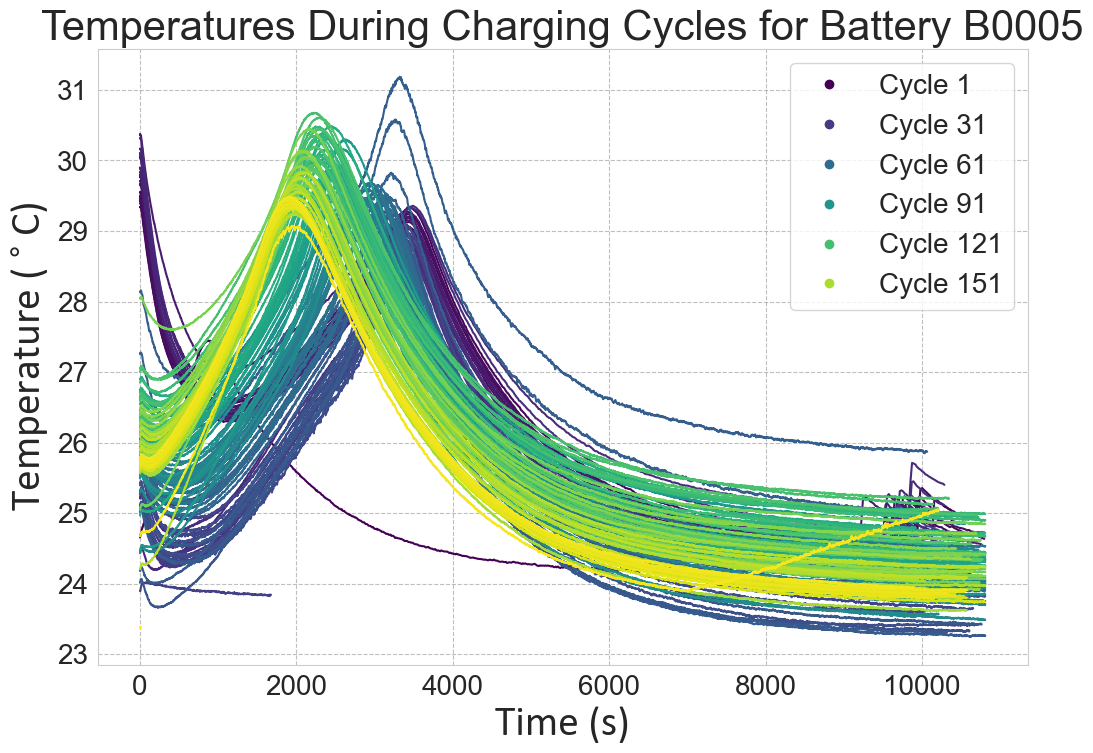

In [55]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_5))

for cycle in range(1, charging_cycles_5 + 1):
    
    # Extract data for each cycle
    cycle_data_5 = charge_dataset_5.loc[charge_dataset_5['cycle'] == cycle, ['time', 'temperature_measured']]
    
    # To remove Overshoot, clip at 4.2 V
    #cycle_data['voltage_measured'] = np.clip(cycle_data['voltage_measured'], a_min=None, a_max=4.2)

    # Plot each cycle with a different color
    plt.plot(cycle_data_5['time'], cycle_data_5['temperature_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_5, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontname='Calibri', fontsize=30)
plt.title('Temperatures During Charging Cycles for Battery B0005', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
folder_n= '7. Charge Plots'

# Create the directory if it doesn't exist
if not os.path.exists(folder_n):
    os.makedirs(folder_n)

plt.savefig(os.path.join(folder_n, 'b0005_temp_ch.pdf'), format='pdf')

# Show the plot
plt.show()


#### Battery B0006

Number of charging cycles:  171


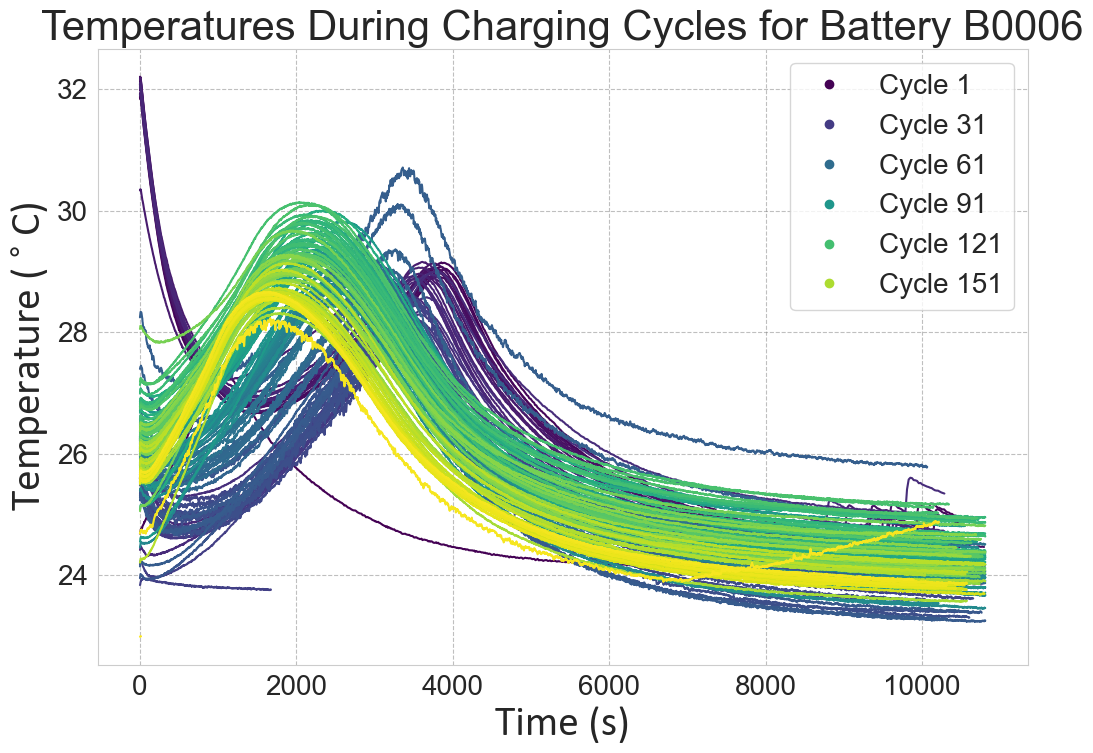

In [56]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_6))

for cycle in range(1, charging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_6 = charge_dataset_6.loc[charge_dataset_6['cycle'] == cycle, ['time', 'temperature_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_6['time'], cycle_data_6['temperature_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_6, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontname='Calibri', fontsize=30)
plt.title('Temperatures During Charging Cycles for Battery B0006', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0006_temp_ch.pdf'), format='pdf')

# Show the plot
plt.show()

#### Battery B0007

Number of charging cycles:  171


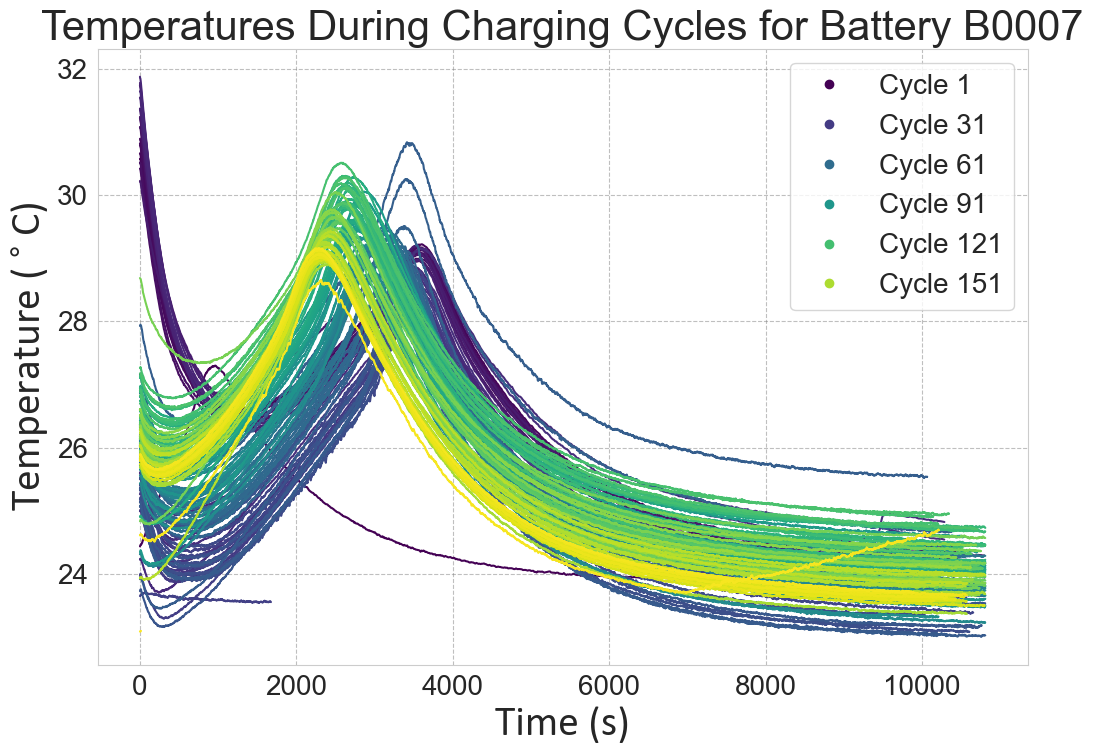

In [57]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_7 = charge_dataset_7.loc[charge_dataset_7['cycle'] == cycle, ['time', 'temperature_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_7['time'], cycle_data_7['temperature_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_7, 30)], fontsize=20)

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontname='Calibri', fontsize=30)
plt.title('Temperatures During Charging Cycles for Battery B0007', fontsize=30)
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])
plt.savefig(os.path.join(folder_n, 'b0007_temp_ch.pdf'), format='pdf')

# Show the plot
plt.show()

### State of Health Calculations

SOH is calculated using the dataset measurements to later be compared with the model's estimation.

#### Battery B0005

In [22]:
# SOH = Ck/C0 * 100

attributes=['cycle', 'datetime', 'capacity']
dis_ele_5 = capacity_5[attributes]              # Assign the data in capacity dataframe to new element 
C = dis_ele_5['capacity'][0]                    # max capacity 1.85 Ah not rated 2 Ah
for i in range(len(dis_ele_5)):
    dis_ele_5['SoH']=(dis_ele_5['capacity'])/C  # Assign new attribute in dis_ele for SOH
print(dis_ele_5.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


#### Battery B0006

In [23]:
# SOH = Ck/C0 * 100

attributes=['cycle', 'datetime', 'capacity']
dis_ele_6 = capacity_6[attributes]              # Assign the data in capacity dataframe to new element 
C = dis_ele_6['capacity'][0]                  # max capacity 1.85 Ah not rated 2 Ah
for i in range(len(dis_ele_6)):
    dis_ele_6['SoH']=(dis_ele_6['capacity'])/C  # Assign new attribute in dis_ele for SOH
print(dis_ele_6.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  2.035338  1.000000
1      2 2008-04-02 19:43:48  2.025140  0.994990
2      3 2008-04-03 00:01:06  2.013326  0.989185
3      4 2008-04-03 04:16:37  2.013285  0.989165
4      5 2008-04-03 08:33:25  2.000528  0.982898


#### Battery B0007

In [24]:
# SOH = Ck/C0 * 100

attributes=['cycle', 'datetime', 'capacity']
dis_ele_7 = capacity_7[attributes]              # Assign the data in capacity dataframe to new element 
C = dis_ele_7['capacity'][0]                  # max capacity 1.85 Ah not rated 2 Ah
for i in range(len(dis_ele_7)):
    dis_ele_7['SoH']=(dis_ele_7['capacity'])/C  # Assign new attribute in dis_ele for SOH
print(dis_ele_7.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.891052  1.000000
1      2 2008-04-02 19:43:48  1.880637  0.994492
2      3 2008-04-03 00:01:06  1.880663  0.994506
3      4 2008-04-03 04:16:37  1.880771  0.994563
4      5 2008-04-03 08:33:25  1.879451  0.993865


#### Battery B0018

In [25]:
# SOH = Ck/C0 * 100

attributes=['cycle', 'datetime', 'capacity']
dis_ele_18 = capacity_18[attributes]              # Assign the data in capacity dataframe to new element 
C = dis_ele_18['capacity'][0]                  # max capacity 1.85 Ah not rated 2 Ah
for i in range(len(dis_ele_18)):
    dis_ele_18['SoH']=(dis_ele_18['capacity'])/C  # Assign new attribute in dis_ele for SOH
print(dis_ele_18.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-07-07 15:15:28  1.855005  1.000000
1      2 2008-07-07 21:53:06  1.843196  0.993634
2      3 2008-07-08 02:56:08  1.839602  0.991697
3      4 2008-07-08 07:58:55  1.830674  0.986884
4      5 2008-07-08 18:57:48  1.832700  0.987976


### SOH Plot

Each cycle's SOH is plotted below.
A horizontal line represents the EOL criteria which is 70% (isn't this SOC?)

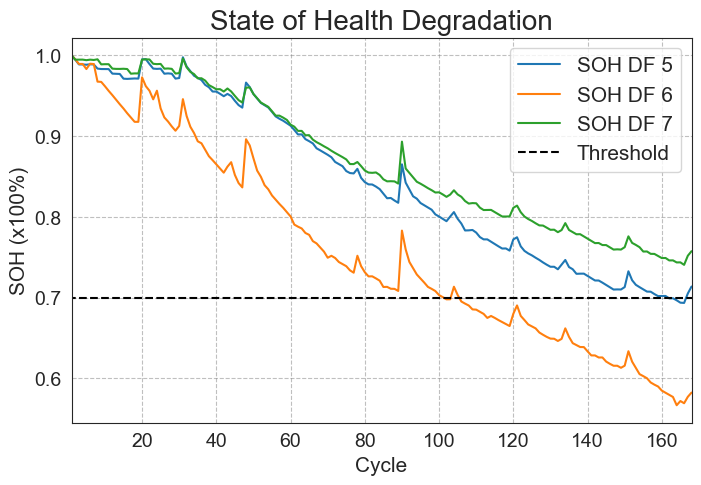

In [26]:

# Assuming dis_ele_5, dis_ele_6, dis_ele_7, dis_ele_18 are your datasets
# Make sure to replace dis_ele_5, dis_ele_6, etc., with your actual dataframe names

soh_df_5 = dis_ele_5.loc[(dis_ele_5['cycle'] >= 1), ['cycle', 'SoH']]
soh_df_6 = dis_ele_6.loc[(dis_ele_6['cycle'] >= 1), ['cycle', 'SoH']]
soh_df_7 = dis_ele_7.loc[(dis_ele_7['cycle'] >= 1), ['cycle', 'SoH']]
soh_df_18 = dis_ele_18.loc[(dis_ele_18['cycle'] >= 1), ['cycle', 'SoH']]

sns.set_style("white")
plt.figure(figsize=(8, 5))

# Plot each SOH dataframe
plt.plot(soh_df_5['cycle'], soh_df_5['SoH'], label='SOH DF 5')
plt.plot(soh_df_6['cycle'], soh_df_6['SoH'], label='SOH DF 6')
plt.plot(soh_df_7['cycle'], soh_df_7['SoH'], label='SOH DF 7')
#plt.plot(soh_df_18['cycle'], soh_df_18['SoH'], label='SOH DF 18')

# Draw SOH threshold line
plt.plot([0., max(len(dis_ele_5), len(dis_ele_6), len(dis_ele_7), len(dis_ele_18))], [0.70, 0.70], color='black', linestyle='--', label='Threshold')

# Labeling and titling
plt.ylabel('SOH (x100%)', fontsize=15)
plt.xlabel('Cycle', fontsize=15)
plt.title('State of Health Degradation', fontsize=20)
plt.legend(fontsize=15)  # Add a legend to distinguish the lines

# Formatting
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)
# Make axis tick labels larger
plt.tick_params(axis='both', which='major', labelsize=14)
# Set axis limits
plt.xlim(soh_df_5['cycle'].min(), soh_df_5['cycle'].max())
plt.savefig('soh_degradation.pdf', format='pdf')

plt.show()


## Data Preprocessing

Removing overshoots and applying the moving average to minimize sensor noise and avoid overfitting.

### Clipping Overshoots/Outliers

First I will need to remove the outliers from the charging voltage profiles, which exceeded the maximum value of 4.2 V. The values will be clipped, and added to the new dataframes.

#### Battery B0005

In [27]:
# Creating a new DataFrame by copying charge_dataset_18
charge_dataset_clipped_5 = charge_dataset_5.copy()

# Clipping the 'voltage_measured' column at 4.2 V
charge_dataset_clipped_5['voltage_measured'] = charge_dataset_clipped_5['voltage_measured'].clip(upper=4.2)

# Now charge_dataset_clipped_18 has the 'voltage_measured' column values clipped at 4.2 V

print(charge_dataset_clipped_5)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.873017   
1           1                   24 2008-04-02 13:08:17          3.479394   
2           1                   24 2008-04-02 13:08:17          4.000588   
3           1                   24 2008-04-02 13:08:17          4.012395   
4           1                   24 2008-04-02 13:08:17          4.019708   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          0.236356   
541169    170                   24 2008-05-28 11:09:42          0.003365   
541170    170                   24 2008-05-28 11:09:42          4.200000   
541171    170                   24 2008-05-28 11:09:42          4.200000   
541172    170                   24 2008-05-28 11:09:42          4.200000   

        current_measured  temperature_measured  current_charge  \
0              -0.001

Number of charging cycles:  171


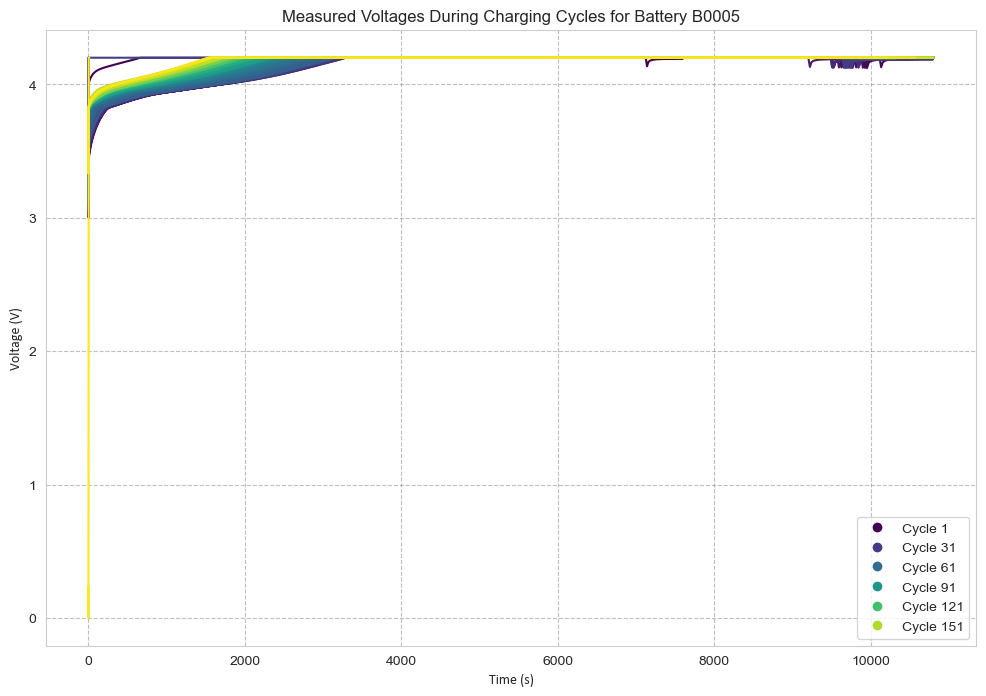

In [28]:
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_5))

for cycle in range(1, charging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_clipped_5 = charge_dataset_clipped_5.loc[charge_dataset_clipped_5['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_clipped_5['time'], cycle_data_clipped_5['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_5, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for Battery B0005')

# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

#### Battery B0006

In [29]:
# Creating a new DataFrame by copying charge_dataset_18
charge_dataset_clipped_6 = charge_dataset_6.copy()

# Clipping the 'voltage_measured' column at 4.2 V
charge_dataset_clipped_6['voltage_measured'] = charge_dataset_clipped_6['voltage_measured'].clip(upper=4.2)

# Now charge_dataset_clipped_18 has the 'voltage_measured' column values clipped at 4.2 V

print(charge_dataset_clipped_6)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.864624   
1           1                   24 2008-04-02 13:08:17          3.469113   
2           1                   24 2008-04-02 13:08:17          3.994806   
3           1                   24 2008-04-02 13:08:17          4.005888   
4           1                   24 2008-04-02 13:08:17          4.012944   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          0.979650   
541169    170                   24 2008-05-28 11:09:42         -0.001422   
541170    170                   24 2008-05-28 11:09:42          4.200000   
541171    170                   24 2008-05-28 11:09:42          4.200000   
541172    170                   24 2008-05-28 11:09:42          4.186010   

        current_measured  temperature_measured  current_charge  \
0               0.000

Number of charging cycles:  171


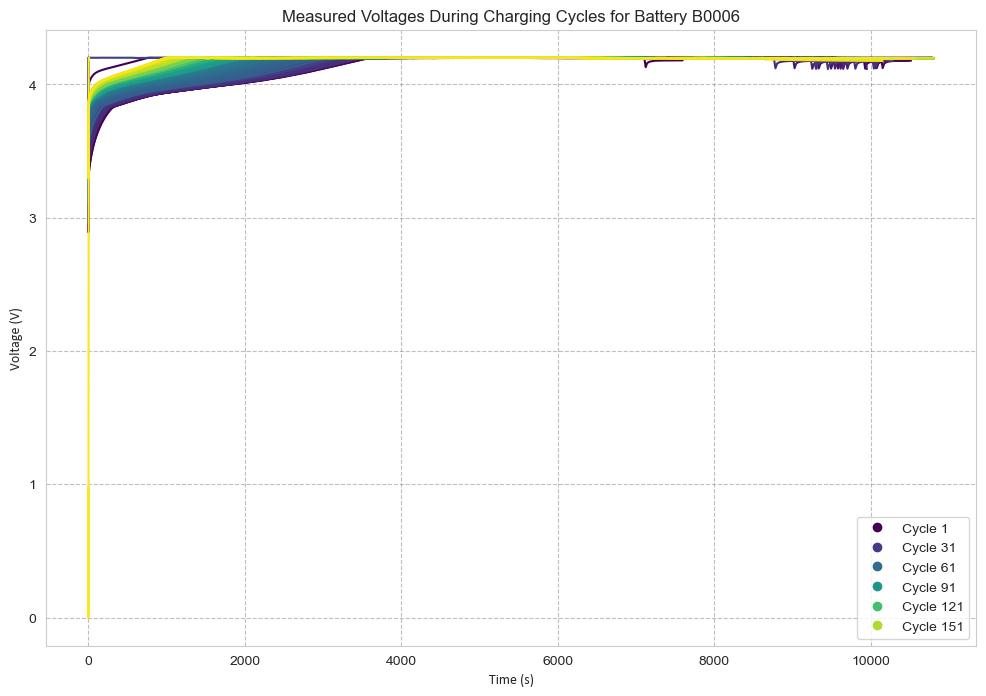

In [30]:
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_clipped_6 = charge_dataset_clipped_6.loc[charge_dataset_clipped_6['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_clipped_6['time'], cycle_data_clipped_6['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_6, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for Battery B0006')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

#### Battery B0007

In [31]:
# Creating a new DataFrame by copying charge_dataset_18
charge_dataset_clipped_7 = charge_dataset_7.copy()

# Clipping the 'voltage_measured' column at 4.2 V
charge_dataset_clipped_7['voltage_measured'] = charge_dataset_clipped_7['voltage_measured'].clip(upper=4.2)

# Now charge_dataset_clipped_18 has the 'voltage_measured' column values clipped at 4.2 V

print(charge_dataset_clipped_7)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.866123   
1           1                   24 2008-04-02 13:08:17          3.644900   
2           1                   24 2008-04-02 13:08:17          4.001099   
3           1                   24 2008-04-02 13:08:17          4.011041   
4           1                   24 2008-04-02 13:08:17          4.017485   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          0.762597   
541169    170                   24 2008-05-28 11:09:42          0.002932   
541170    170                   24 2008-05-28 11:09:42          4.200000   
541171    170                   24 2008-05-28 11:09:42          4.200000   
541172    170                   24 2008-05-28 11:09:42          4.200000   

        current_measured  temperature_measured  current_charge  \
0              -0.003

Number of charging cycles:  171


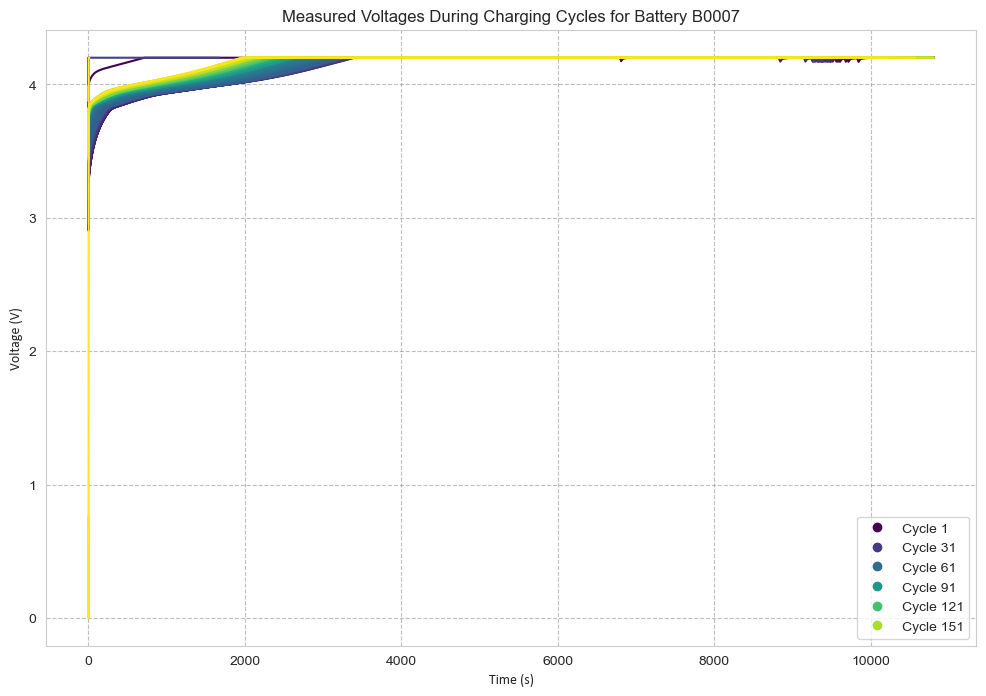

In [32]:
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_clipped_7 = charge_dataset_clipped_7.loc[charge_dataset_clipped_7['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_clipped_7['time'], cycle_data_clipped_7['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_7, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for Battery B0007')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

#### Battery B0018


In [33]:
# Creating a new DataFrame by copying charge_dataset_18
charge_dataset_clipped_18 = charge_dataset_18.copy()

# Clipping the 'voltage_measured' column at 4.2 V
charge_dataset_clipped_18['voltage_measured'] = charge_dataset_clipped_18['voltage_measured'].clip(upper=4.2)

# Now charge_dataset_clipped_18 has the 'voltage_measured' column values clipped at 4.2 V

print(charge_dataset_clipped_18)


        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-07-07 12:26:45          3.865713   
1           1                   24 2008-07-07 12:26:45          3.447651   
2           1                   24 2008-07-07 12:26:45          4.005559   
3           1                   24 2008-07-07 12:26:45          4.015989   
4           1                   24 2008-07-07 12:26:45          4.023230   
...       ...                  ...                 ...               ...   
279805    134                   24 2008-08-20 05:49:31          4.180760   
279806    134                   24 2008-08-20 05:49:31          4.181660   
279807    134                   24 2008-08-20 05:49:31          4.182311   
279808    134                   24 2008-08-20 05:49:31          4.182857   
279809    134                   24 2008-08-20 05:49:31          4.183212   

        current_measured  temperature_measured  current_charge  \
0               0.001

Number of charging cycles:  135


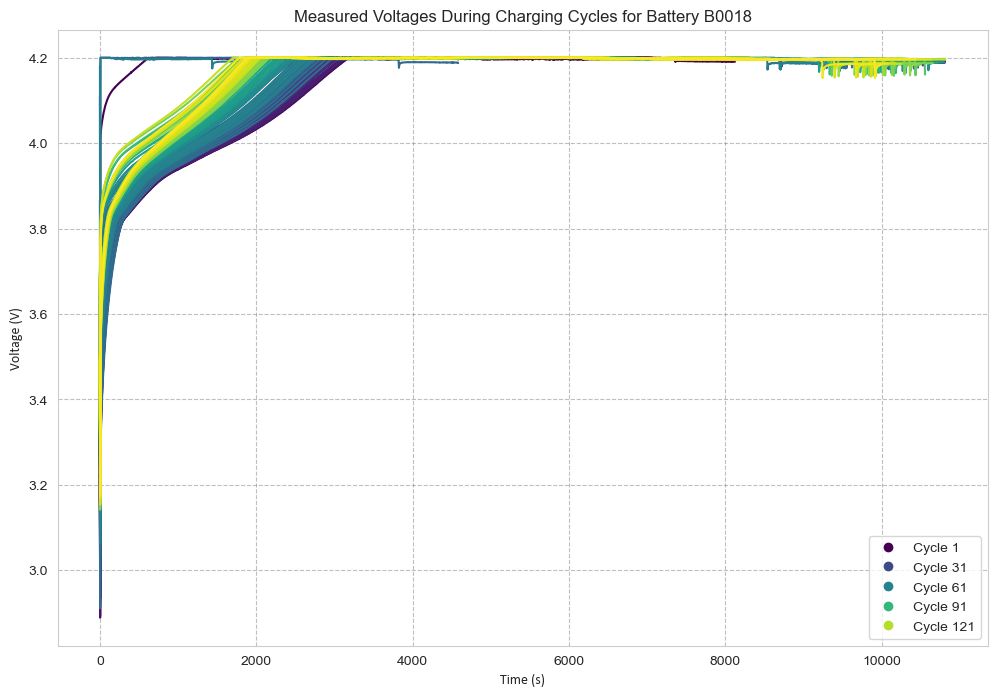

In [34]:
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_18))

for cycle in range(1, charging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_clipped_18 = charge_dataset_clipped_18.loc[charge_dataset_clipped_18['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_clipped_18['time'], cycle_data_clipped_18['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_18, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for Battery B0018')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()


### Moving Average

Update: Won't be used here. The average is taking when reshaping the input of neural networks.

I still need to update the discharge data set with the clipped voltages before applying this to every battery. DONE

Check how windowsize impacts neural network performance. 

#### Battery B0005

In [35]:
# Creating a new DataFrame by copying charge_dataset_clipped_5
charge_dataset_avg_5 = charge_dataset_clipped_5.copy()

# Computing the moving average for 'voltage_measured' with a window size of 10
charge_dataset_avg_5['voltage_measured'] = charge_dataset_avg_5['voltage_measured'].rolling(window=25, min_periods=1).mean()

# Computing the moving average for 'current_measured' with a window size of 10
charge_dataset_avg_5['current_measured'] = charge_dataset_avg_5['current_measured'].rolling(window=25, min_periods=1).mean()

# Now charge_dataset_avg_5 has the moving averages of the specified columns

print(charge_dataset_avg_5)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.873017   
1           1                   24 2008-04-02 13:08:17          3.676205   
2           1                   24 2008-04-02 13:08:17          3.784333   
3           1                   24 2008-04-02 13:08:17          3.841348   
4           1                   24 2008-04-02 13:08:17          3.877020   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          4.041454   
541169    170                   24 2008-05-28 11:09:42          3.873589   
541170    170                   24 2008-05-28 11:09:42          3.873589   
541171    170                   24 2008-05-28 11:09:42          3.873589   
541172    170                   24 2008-05-28 11:09:42          3.873589   

        current_measured  temperature_measured  current_charge  \
0              -0.001

##### Voltage Plot

Number of charging cycles:  171


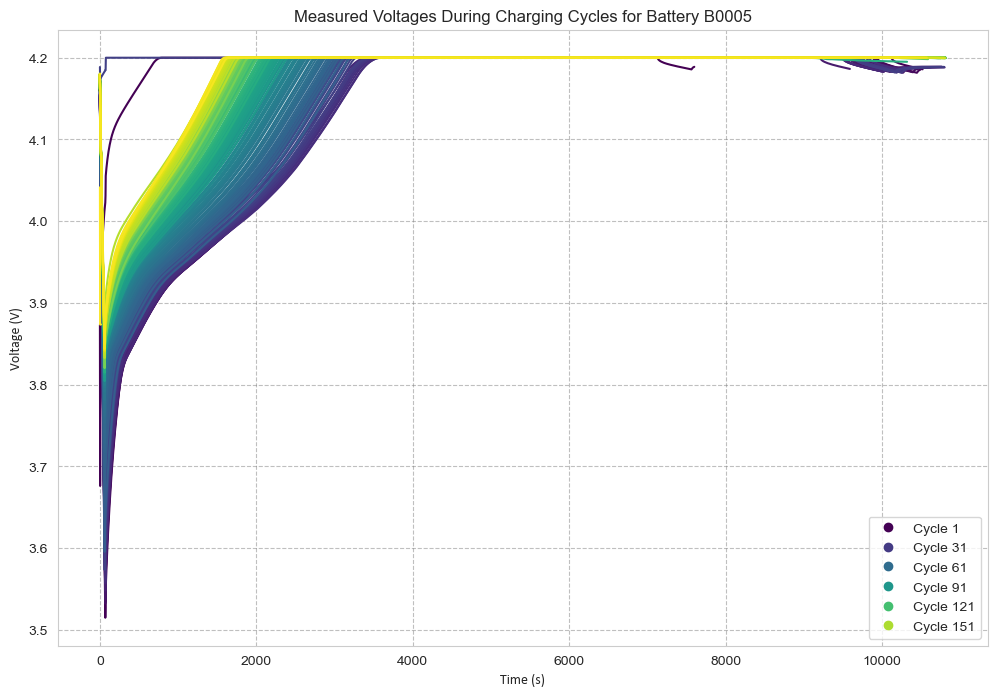

In [36]:
# Voltage Plot
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_5))

for cycle in range(1, charging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_avg_5 = charge_dataset_avg_5.loc[charge_dataset_avg_5['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_5['time'], cycle_data_avg_5['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_5, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for Battery B0005')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

##### Current Plot

Number of charging cycles:  171


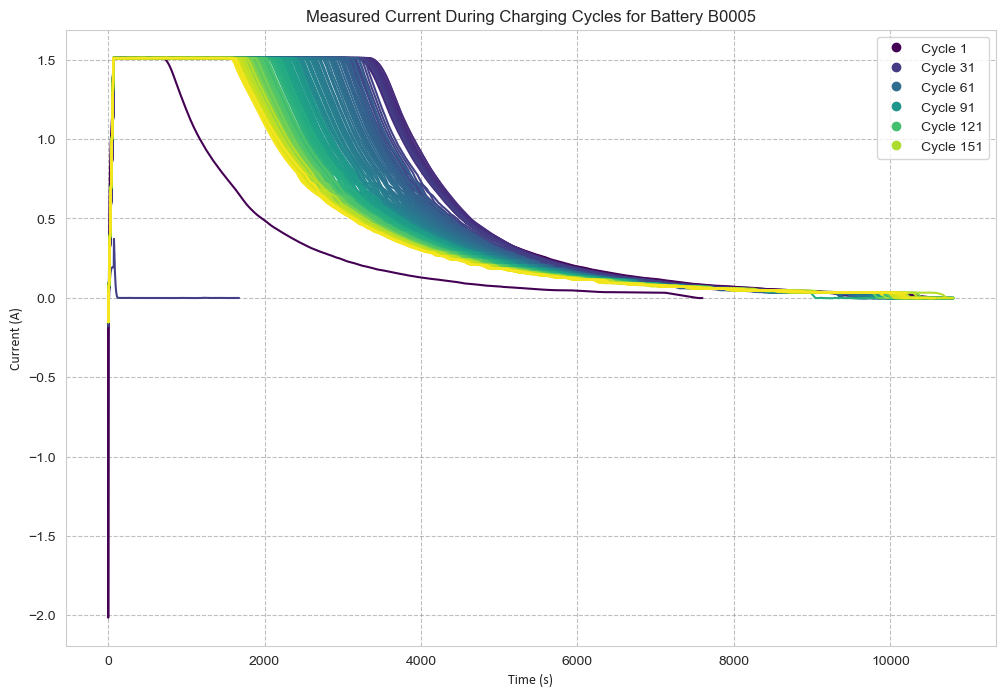

In [37]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_5)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_5))

for cycle in range(1, charging_cycles_5 + 1):
    # Extract data for each cycle
    cycle_data_avg_5 = charge_dataset_avg_5.loc[charge_dataset_avg_5['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_5['time'], cycle_data_avg_5['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_5), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_5, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Current (A)', fontname='Calibri')
plt.title('Measured Current During Charging Cycles for Battery B0005')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

#### Battery B0006

In [38]:
# Creating a new DataFrame by copying charge_dataset_clipped_18
charge_dataset_avg_6 = charge_dataset_clipped_6.copy()

# Computing the moving average for 'voltage_measured' with a window size of 10
charge_dataset_avg_6['voltage_measured'] = charge_dataset_avg_6['voltage_measured'].rolling(window=25, min_periods=1).mean()

# Computing the moving average for 'current_measured' with a window size of 10
charge_dataset_avg_6['current_measured'] = charge_dataset_avg_6['current_measured'].rolling(window=25, min_periods=1).mean()

# Now charge_dataset_avg_18 has the moving averages of the specified columns

print(charge_dataset_avg_6)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.864624   
1           1                   24 2008-04-02 13:08:17          3.666868   
2           1                   24 2008-04-02 13:08:17          3.776181   
3           1                   24 2008-04-02 13:08:17          3.833608   
4           1                   24 2008-04-02 13:08:17          3.869475   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          4.067367   
541169    170                   24 2008-05-28 11:09:42          3.899480   
541170    170                   24 2008-05-28 11:09:42          3.899639   
541171    170                   24 2008-05-28 11:09:42          3.899801   
541172    170                   24 2008-05-28 11:09:42          3.899407   

        current_measured  temperature_measured  current_charge  \
0               0.000

##### Voltage Plot

Number of charging cycles:  171


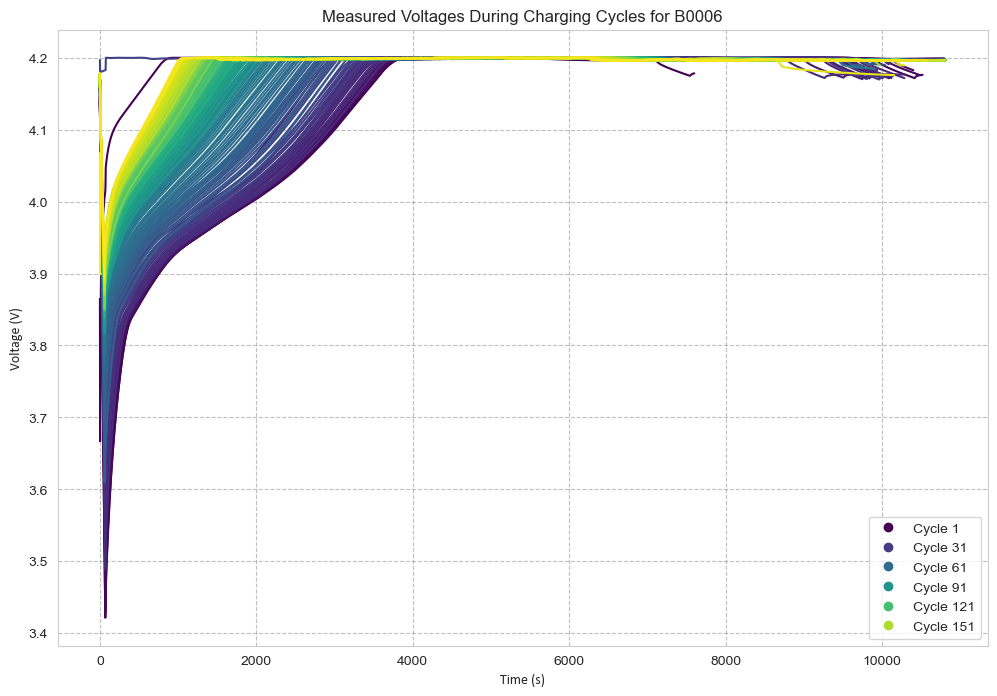

In [39]:
# Voltage Plot
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_6))

for cycle in range(1, charging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_avg_6 = charge_dataset_avg_6.loc[charge_dataset_avg_6['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_6['time'], cycle_data_avg_6['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_6, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for B0006')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

##### Current Plot

Number of charging cycles:  171


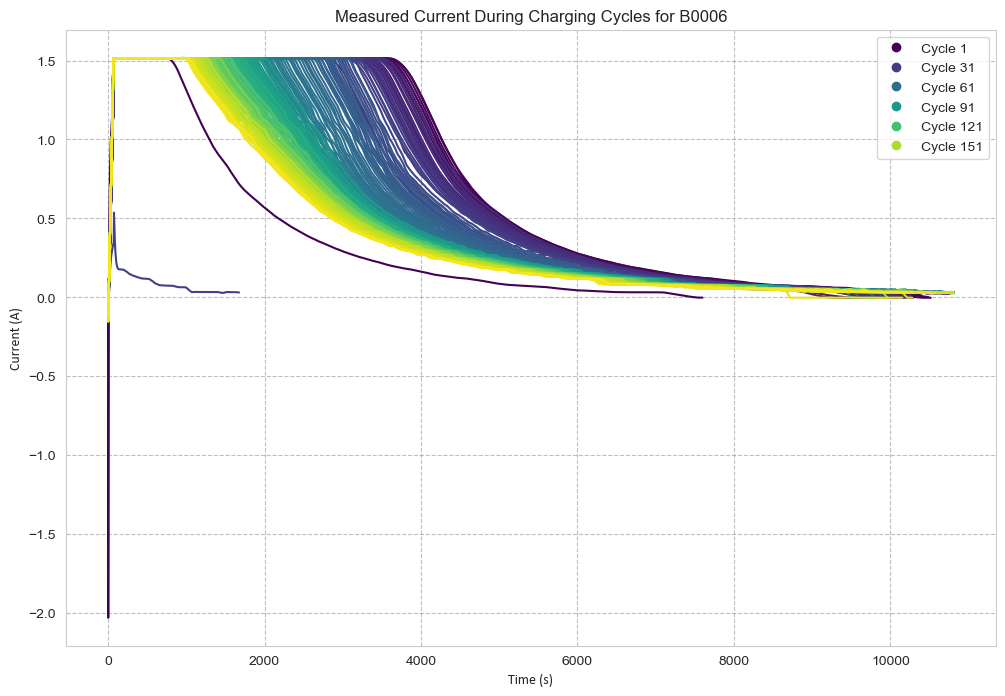

In [41]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_6)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_6))

for cycle in range(1, charging_cycles_6 + 1):
    # Extract data for each cycle
    cycle_data_avg_6 = charge_dataset_avg_6.loc[charge_dataset_avg_6['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_6['time'], cycle_data_avg_6['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_6), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_6, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Current (A)', fontname='Calibri')
plt.title('Measured Current During Charging Cycles for B0006')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

#### Battery B0007

In [42]:
# Creating a new DataFrame by copying charge_dataset_clipped_18
charge_dataset_avg_7 = charge_dataset_clipped_7.copy()

# Computing the moving average for 'voltage_measured' with a window size of 10
charge_dataset_avg_7['voltage_measured'] = charge_dataset_avg_7['voltage_measured'].rolling(window=25, min_periods=1).mean()

# Computing the moving average for 'current_measured' with a window size of 10
charge_dataset_avg_7['current_measured'] = charge_dataset_avg_7['current_measured'].rolling(window=25, min_periods=1).mean()

# Now charge_dataset_avg_18 has the moving averages of the specified columns

print(charge_dataset_avg_7)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.866123   
1           1                   24 2008-04-02 13:08:17          3.755511   
2           1                   24 2008-04-02 13:08:17          3.837374   
3           1                   24 2008-04-02 13:08:17          3.880791   
4           1                   24 2008-04-02 13:08:17          3.908130   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          4.062504   
541169    170                   24 2008-05-28 11:09:42          3.894621   
541170    170                   24 2008-05-28 11:09:42          3.894621   
541171    170                   24 2008-05-28 11:09:42          3.894621   
541172    170                   24 2008-05-28 11:09:42          3.894621   

        current_measured  temperature_measured  current_charge  \
0              -0.003

##### Voltage Plot

Number of charging cycles:  171


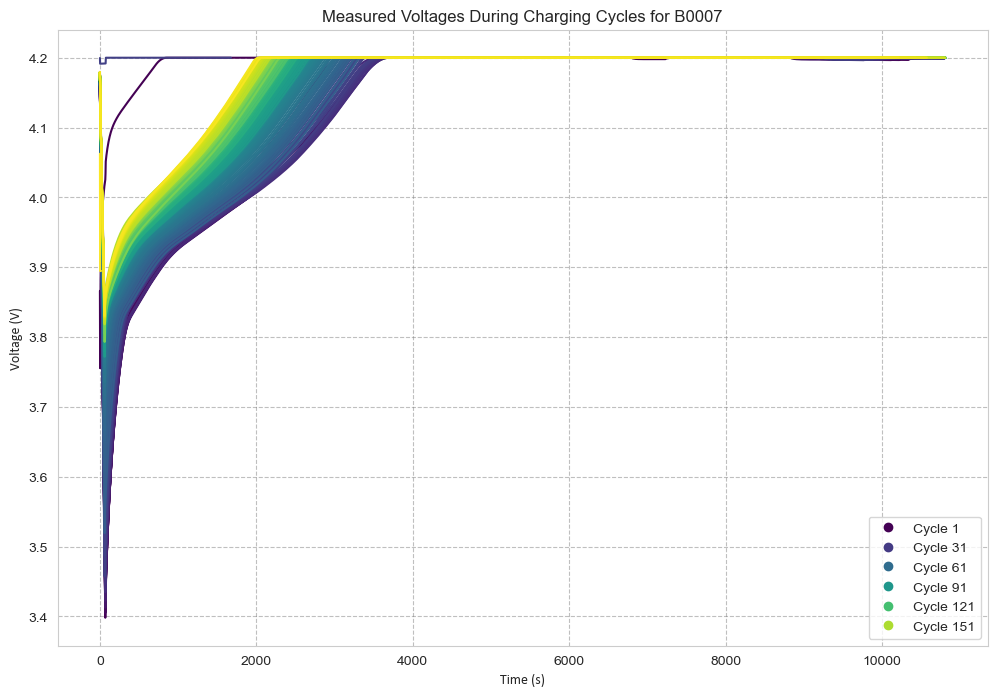

In [43]:
# Voltage Plot
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_7 + 1):
    # Extract data for each cycle
    cycle_data_avg_7 = charge_dataset_avg_7.loc[charge_dataset_avg_7['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_7['time'], cycle_data_avg_7['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_7, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for B0007')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

##### Current Plot

Number of charging cycles:  171


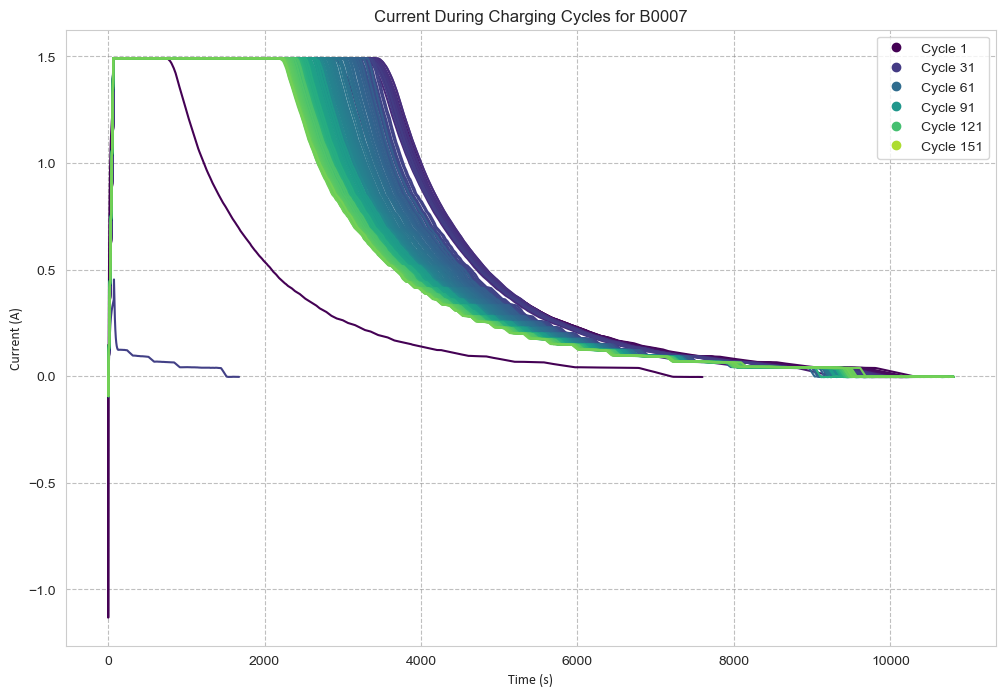

In [44]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_7)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_7))

for cycle in range(1, charging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_avg_7 = charge_dataset_avg_7.loc[charge_dataset_avg_7['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_7['time'], cycle_data_avg_7['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_7), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_7, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Current (A)', fontname='Calibri')
plt.title('Current During Charging Cycles for B0007')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

#### Battery B0018

In [45]:
# Creating a new DataFrame by copying charge_dataset_clipped_18
charge_dataset_avg_18 = charge_dataset_clipped_18.copy()

# Computing the moving average for 'voltage_measured' with a window size of 10
charge_dataset_avg_18['voltage_measured'] = charge_dataset_avg_18['voltage_measured'].rolling(window=25, min_periods=1).mean()

# Computing the moving average for 'current_measured' with a window size of 10
charge_dataset_avg_18['current_measured'] = charge_dataset_avg_18['current_measured'].rolling(window=25, min_periods=1).mean()

# Now charge_dataset_avg_18 has the moving averages of the specified columns

print(charge_dataset_avg_18)

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-07-07 12:26:45          3.865713   
1           1                   24 2008-07-07 12:26:45          3.656682   
2           1                   24 2008-07-07 12:26:45          3.772974   
3           1                   24 2008-07-07 12:26:45          3.833728   
4           1                   24 2008-07-07 12:26:45          3.871628   
...       ...                  ...                 ...               ...   
279805    134                   24 2008-08-20 05:49:31          4.189794   
279806    134                   24 2008-08-20 05:49:31          4.189222   
279807    134                   24 2008-08-20 05:49:31          4.188669   
279808    134                   24 2008-08-20 05:49:31          4.188141   
279809    134                   24 2008-08-20 05:49:31          4.187637   

        current_measured  temperature_measured  current_charge  \
0               0.001

##### Voltage Plot

Number of charging cycles:  135


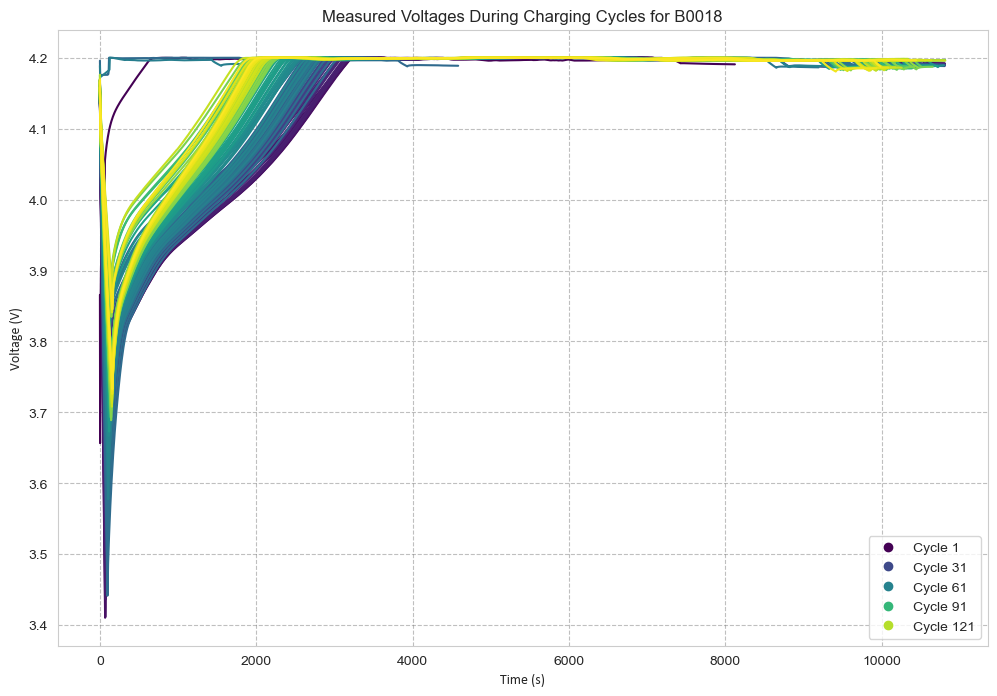

In [46]:
# Voltage Plot
# To plot the changes
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_18))

for cycle in range(1, charging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_avg_18 = charge_dataset_avg_18.loc[charge_dataset_avg_18['cycle'] == cycle, ['time', 'voltage_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_18['time'], cycle_data_avg_18['voltage_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_18, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Voltage (V)', fontname='Calibri')
plt.title('Measured Voltages During Charging Cycles for B0018')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()

##### Current Plot

Number of charging cycles:  135


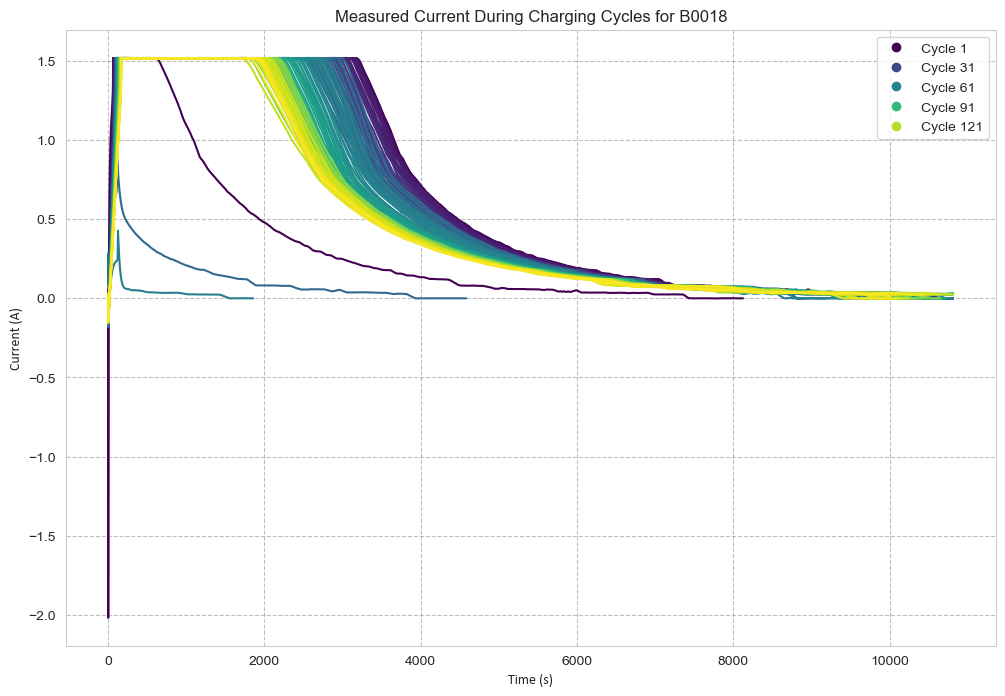

In [47]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

print('Number of charging cycles: ',charging_cycles_18)

# Generate a color map to differentiate cycles visually
colors = cm.viridis(np.linspace(0, 1, charging_cycles_18))

for cycle in range(1, charging_cycles_18 + 1):
    # Extract data for each cycle
    cycle_data_avg_18 = charge_dataset_avg_18.loc[charge_dataset_avg_18['cycle'] == cycle, ['time', 'current_measured']]
    
    # Plot each cycle with a different color
    plt.plot(cycle_data_avg_18['time'], cycle_data_avg_18['current_measured'], label=f'Cycle {cycle}', color=colors[cycle-1])

# Limit the number of legend entries because too many can clutter the plot
plt.legend(handles=[plt.Line2D([0], [0], color=cm.viridis(i/charging_cycles_18), marker='o', linestyle='', label=f'Cycle {i+1}') for i in range(0, charging_cycles_18, 30)])

# Set labels and title
plt.xlabel('Time (s)', fontname='Calibri')
plt.ylabel('Current (A)', fontname='Calibri')
plt.title('Measured Current During Charging Cycles for B0018')
# Enable the grid
plt.grid(True, linestyle='--', which='both', axis='both', color='gray', alpha=0.5)

# Optionally, adjust the x-axis and y-axis limits if needed
# plt.xlim([min_time, max_time])
# plt.ylim([min_voltage, max_voltage])

# Show the plot
plt.show()